# Vehicle Insurance Fraud Detection<br> with Gradient Boosting #

## Business Problem ##

This project aims to build a model that can predict whether a vehicle insurance claim is fraud based on 30 different input features. Fraudulent claims are costly to both the company and the customer, as they can drive up premiums as the cost of doing business becomes higher. The ability to flag transactions as likely fraudulent allows for more targeted fraud detection. The challenge is to flag as many 'actual fraud' claims while not flagging too many non-fraudulent claims, since this increases the follow on work to investigate the claim.  

For this reason, we will rely heavily on the balance between the False Negative Rate (FNR) and the False Positive Rate (FPR) to determine if the model is performing well.  It is more important to identify fraud than have a higher accuracy, but this can't result in flagging everything.

## Data Understanding ##

The data for this project came from Kaggle __[(Kaggle Dataset Link)](https://www.kaggle.com/shivamb/vehicle-claim-fraud-detection)__ and originated with the company Oracle. It is somewhat old (from the 90s), but was one of the larger datasets available for insurance claim fraud detection.  While there may be additional claim data available today, all of these categories are still applicable and should still be expected to provide reasonable predictions in present day.

This data has a significant class imbalance. Only 6% of the claims listed are labeled as fraudulent. This can be addressed using class weighting in the model or oversampling. Undersampling would be difficult for this data since there are so few fraudulent claims. The three oversampling methods that I tried are RandomOverSample, SMOTE, and ADASYN. Ultimately, class weighting performed the best in the Gradient Boosting models. 

# Approach #



## Data Exploration ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn import pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import random
import xgboost as xgb
import seaborn as sns
import catboost
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold
import shap
%matplotlib inline

In [2]:
df=pd.read_csv('fraud_oracle.csv')
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [4]:
df['FraudFound_P'].value_counts(normalize=True)

0    0.940143
1    0.059857
Name: FraudFound_P, dtype: float64

In [5]:
cols=df.columns

for col in cols:
    print(df[col].value_counts())

Jan    1411
May    1367
Mar    1360
Jun    1321
Oct    1305
Dec    1285
Apr    1280
Feb    1266
Jul    1257
Sep    1240
Nov    1201
Aug    1127
Name: Month, dtype: int64
3    3640
2    3558
4    3398
1    3187
5    1637
Name: WeekOfMonth, dtype: int64
Monday       2616
Friday       2445
Tuesday      2300
Thursday     2173
Wednesday    2159
Saturday     1982
Sunday       1745
Name: DayOfWeek, dtype: int64
Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: Make, dtype: int64
Urban    13822
Rural     1598
Name: AccidentArea, dtype: int64
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
0               1
Name: DayOfWeekCla

In [6]:
df[df['DayOfWeekClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


There is only one row with missing data. Drop this observation.

In [7]:
df=df[df['DayOfWeekClaimed']!='0']

Year, Policy number and Rep Number can be dropped from features since they are not predictors of Fraud. If a certain policy holder or rep is involved in vehicle fraud then it is possible that this could be used to identify fraud, but it will not help with general classification of claims.

In [8]:
df.drop(columns=['PolicyNumber','RepNumber','Year'],inplace=True)

In [9]:
#Look at rows where Age is 0
df[df['Age']==0]['AgeOfPolicyHolder'].value_counts()

16 to 17    319
Name: AgeOfPolicyHolder, dtype: int64

All rows where Age is 0 show the age of policy holder '16 to 17'. Lets look if age of policy holder tends to correspond to Age.

In [10]:
df.groupby('AgeOfPolicyHolder')['Age'].mean()

AgeOfPolicyHolder
16 to 17     0.000000
18 to 20    16.400000
21 to 25    18.814815
26 to 30    22.941272
31 to 35    30.548006
36 to 40    40.483304
41 to 50    50.423267
51 to 65    60.441092
over 65     72.783465
Name: Age, dtype: float64

The mean values don't perfectly correspond, which can be expected since the person involved in a claim is not always the policy holder. But, they do correspond to roughly the age range, so we will assume that the 16 to 17 category corresponds to an age of 16 so that we don't lose those rows of data.

In [11]:
df['Age']=df['Age'].apply(lambda x: 16 if x==0 else x)

In [12]:
df.groupby('AgeOfPolicyHolder')['Age'].mean()

AgeOfPolicyHolder
16 to 17    16.000000
18 to 20    16.400000
21 to 25    18.814815
26 to 30    22.941272
31 to 35    30.548006
36 to 40    40.483304
41 to 50    50.423267
51 to 65    60.441092
over 65     72.783465
Name: Age, dtype: float64

### Convert Feature Data Types ###

A number of the features are in object format when they could be numeric. This includes month, week, vehicle age, number of supplements. Some have difficult formats to deal with where one of the categories is "greater than" a certain value.  We'll create identifier features for these while setting the values in the numeric column to -1.

In [13]:
# Correct Month and MonthClaimed columns
month_map={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,
          'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

df['Month']=df['Month'].map(month_map)
df['MonthClaimed']=df['MonthClaimed'].map(month_map)

In [14]:
#Correct DayOfWeek and DayOfWeekClaimed
day_map={'Sunday':1,'Monday':2,'Tuesday':3,'Wednesday':4,'Thursday':5,
        'Friday':6,'Saturday':7}

df['DayOfWeek']=df['DayOfWeek'].map(day_map)
df['DayOfWeekClaimed']=df['DayOfWeekClaimed'].map(day_map)

In [15]:
#replace vehicle price ranges with random prices in that range

def fix_vehicle_price(x):
    if x=='less than 20000':
        return random.randint(5000,19999)
    elif x=='more than 69000':
        return random.randint(70000,89000)
    else:
        lower=int(x[:5])
        upper=int(x[-5:])
        return random.randint(lower,upper)

df['VehiclePrice']=df['VehiclePrice'].apply(fix_vehicle_price)

In [16]:
#Examine Days_Policy_Accident and Days_Policy_Claim
print(df['Days_Policy_Accident'].value_counts())
print(df['Days_Policy_Claim'].value_counts())

more than 30    15246
8 to 15            55
none               55
15 to 30           49
1 to 7             14
Name: Days_Policy_Accident, dtype: int64
more than 30    15342
15 to 30           56
8 to 15            21
Name: Days_Policy_Claim, dtype: int64


Because only ~1% of all claims in the data set had accidents/claims less than 30 after buying policy, we will create new columns denoting 'accident less than 30 day policy' and 'claim less than 30 day policy' and delete the original columns

In [17]:
df['Less30DaysPolicyAccident']=df['Days_Policy_Accident'].apply(
    lambda x: 0 if x=='more than 30' else 1
)
df['Less30DaysPolicyClaim']=df['Days_Policy_Claim'].apply(
    lambda x: 0 if x=='more than 30' else 1
)
df.drop(columns=['Days_Policy_Accident','Days_Policy_Claim'],inplace=True)

In [18]:
#Examine AgeOfVehicle
df['AgeOfVehicle'].value_counts()

7 years        5807
more than 7    3981
6 years        3448
5 years        1357
new             372
4 years         229
3 years         152
2 years          73
Name: AgeOfVehicle, dtype: int64

Convert these values to numbers. New will be 1. More than 7, set to 10 and have identifying column.

In [19]:
vehicle_age_map={'new': 1,
                '2 years': 2,
                '3 years': 3,
                '4 years': 4,
                '5 years': 5,
                '6 years': 6,
                '7 years': 7,
                'more than 7': 10}  #set to -1
df['AgeOfVehicle']=df['AgeOfVehicle'].map(vehicle_age_map)
df['VehicleAgeOver7']=df['AgeOfVehicle'].apply(
    lambda x: 1 if x==10 else 0
)
df['VehicleAgeOver7'].value_counts()

0    11438
1     3981
Name: VehicleAgeOver7, dtype: int64

In [20]:
#Examine AgeOfPolicyHolder
df['AgeOfPolicyHolder'].value_counts()

31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
26 to 30     613
over 65      508
16 to 17     319
21 to 25     108
18 to 20      15
Name: AgeOfPolicyHolder, dtype: int64

In [21]:
random.seed(42)

In [22]:
#function that returns random age from age range

def fix_age(x):
    if x=='over 65':
        return random.randint(66,78)  #78 is avg life expectancy in us
    else:
        lower=int(x[:2])
        upper=int(x[-2:])
        return random.randint(lower,upper)

In [23]:
df['AgeOfPolicyHolder']=df['AgeOfPolicyHolder'].apply(fix_age)

In [24]:
#Examine NumberOfCars
df['NumberOfCars'].value_counts()

1 vehicle      14315
2 vehicles       709
3 to 4           372
5 to 8            21
more than 8        2
Name: NumberOfCars, dtype: int64

In [25]:
#generate random numbers for categories with range. 
#Only two rows more than 8-enter 9 for these

def fix_num_cars(x):
    if x=='more than 8':
        return 9
    elif x=='3 to 4':
        return random.randint(3,4)
    elif x=='5 to 8':
        return random.randint(5,8)
    else:
        return int(x[0])
    
df['NumberOfCars']=df['NumberOfCars'].apply(fix_num_cars)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Month                     15419 non-null  int64 
 1   WeekOfMonth               15419 non-null  int64 
 2   DayOfWeek                 15419 non-null  int64 
 3   Make                      15419 non-null  object
 4   AccidentArea              15419 non-null  object
 5   DayOfWeekClaimed          15419 non-null  int64 
 6   MonthClaimed              15419 non-null  int64 
 7   WeekOfMonthClaimed        15419 non-null  int64 
 8   Sex                       15419 non-null  object
 9   MaritalStatus             15419 non-null  object
 10  Age                       15419 non-null  int64 
 11  Fault                     15419 non-null  object
 12  PolicyType                15419 non-null  object
 13  VehicleCategory           15419 non-null  object
 14  VehiclePrice          

### Data Preprocessing ###

In [27]:
# Separate target variable and features
y=df['FraudFound_P']
X=df.drop(columns='FraudFound_P')

In [28]:
#One Hot Encode Categorical Variables
X_processed=pd.get_dummies(X)
X_processed.head()

,Month,WeekOfMonth,DayOfWeek,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Age,VehiclePrice,Deductible,DriverRating,...,NumberOfSuppliments_more than 5,NumberOfSuppliments_none,AddressChange_Claim_1 year,AddressChange_Claim_2 to 3 years,AddressChange_Claim_4 to 8 years,AddressChange_Claim_no change,AddressChange_Claim_under 6 months,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,12,5,4,3,1,1,21,71455,300,1,...,0,1,1,0,0,0,0,0,0,1
1,1,3,4,2,1,4,34,71186,400,4,...,0,1,0,0,0,1,0,0,1,0
2,10,5,6,5,11,2,47,87847,400,3,...,0,1,0,0,0,1,0,0,1,0
3,6,2,7,6,7,1,65,20205,400,2,...,1,0,0,0,0,1,0,0,0,1
4,1,5,2,3,2,2,27,86177,400,1,...,0,1,0,0,0,1,0,0,1,0


In [29]:
#train test split 
#stratify y to ensure fraud instances are in both test and train sets

X_train,X_test,y_train,y_test=train_test_split(X_processed,y,random_state=42,
                                              stratify=y)

In [30]:
#Scale test data
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)

In [31]:
X_test_scaled=scaler.transform(X_test)

Before building any models, it is important to note what should be considered good performance based on the class imbalance in the data.  Since only ~6% of the data are classified as fraud, if the model just picked 'not fraud' every time, it would have an accuracy of 96%.  This means any model would need to beat this to be better than just guessing that its not fraud.  

It will also be important to pay attention to recall and precision to determine what types of errors the model tends to have.

### Threshold Selection Considerations ###

The acceptable false negative and false positive rates will depend on the cost of each of these situations.

False negatives mean there was fraud that was not identified. False positives mean that a claim was flagged as fraud even though it is not fraudulent.

While we want to capture as much fraud as possible, since false claims cost the company money, the time/resources spent investigating flagged claims that turn out not to be fraudulent still costs money.  Therefore, we may be willing to accept a certain level of undetected fraud in order to minimize false positives.  

If available, I would also want to examine the distribution of cost of fraud - what is the likelihood that fraud we missed was of a high value vs. likelihood it didn't cost a lot.

For the purpose of this project I'm going to make an assumption that the insurance company can accept missing 10% of all fraud. This may be high, but we do not have the cost information to make an informed selection.

# XGBoost #

XGBoost is a gradient boosting algorithm. 

We can address the class imbalance by adjusting the scale_pos_weight hyperparameter in XGBoost Classifier, but I also tried training the model with oversampled data.  Overall, using class weighting with scale_pos_weight seems to work better, but I left the sections with oversampling for comparison.

We will also make use of early stopping available with XGBoost.  This allows us to stop the model with a specific metric does not improve over a specified number of iterations.  It then returns the model at the iteration with the best score.  This helps to avoid overfitting.  

## Define Functions for Model Comparison ##

Since we are trying to capture as much fraud as possible while preventing false positives from being too high, we will want to look at FNR and FPR at various thresholds for the models we build.  Just looking at accuracy, f1, recall, precision can't as clearly tell us the best performance that model could have if thresholds are shifted.  I think its best to look at the possible solutions with a validation set (a subset of original training split- not the test set) in order to judge how it will ultimately perform.  If we just go based on logloss or AUC, which are the metrics I use to find model solutions, we may not end up with the best performance since we care more about capturing fraud than overall accuracy.  In fact the best model does not have the lowest logloss.

The functions below set up an output with all the desired calculations and threshold tuning graphs for easier comparison of models.

In [33]:
#Function to calculate FNR and FPR

def calc_fpr_fnr(y_true,y_predicted):
    """
    Function takes in y_true and y_predicted and returns fpr and fnr
    """
    
    cm=confusion_matrix(y_true,y_predicted)
    not_fraud=cm[0,:].sum()
    fraud=cm[1,:].sum()
    fnr=cm[1,0]/fraud
    fpr=cm[0,1]/not_fraud
    
    return fpr, fnr

In [34]:
#write a function to make predictions with adjusted threshold

def thresh_pred(probs,threshold):
    """
    Takes in probabilites predicted by model and threshold value
    Return array of classification predictions based on the threshold
    """
    predictions=np.where(probs>threshold,1,0)
    return predictions

In [35]:
def select_threshold_fnr(fnr,thresholds,target_fnr):
    """
    returns the threshold value for the target_fnr and idx value
    """
    #search for value >=target_fnr from end of fnr
    target_fnr=target_fnr
    idx=0
    fn=fnr[0]
    while fn >=target_fnr:
        idx+=1
        fn=fnr[idx]

    #now idx is for value to right of target_fnr
    left_fnr=fnr[idx-1]
    right_fnr=fnr[idx]
    left_threshold=thresholds[idx-1]
    right_threshold=thresholds[idx]

    #find threshold corresponding to target_fnr by linear approximation
    ratio=(left_fnr-target_fnr)/(left_fnr-right_fnr)
    target_thresh=left_threshold-(ratio*(left_threshold-right_threshold))
    if (left_fnr-target_fnr)<=(target_fnr-right_fnr):
        best_idx=idx-1
    else:
        best_idx=idx
    return target_thresh, best_idx

In [36]:
#Function to display all desired metrics and threshold comparisons

def display_metrics(X_test,y_test,y_hat,y_prob):
    """
    Takes in X,y,y_hat,y_prob and displays metrics
    y_prob is array of only probabilities that observation is 1
    """

    #Print Metrics
    fpr,tpr,thresholds=roc_curve(y_test,y_prob)
    print('AUC: {},  logloss: {}'.format(auc(fpr,tpr),log_loss(y_test,y_prob)))
    print('accuracy: {}'.format(round(accuracy_score(y_test,y_hat),4)))
    print('recall: {}'.format(round(recall_score(y_test,y_hat),4)))
    print('precision: {}'.format(round(precision_score(y_test,y_hat),4)))
    print('-------------------')
    print('For a .5 threshold:')
    print(confusion_matrix(y_test,y_hat))
    fpr_5,fnr_5=calc_fpr_fnr(y_test,y_hat)
    print('FPR: {}  FNR: {}'.format(round(fpr_5,4),round(fnr_5,4)))

    #Calculate gmean and corresponding threshold
    gmeans=np.sqrt(tpr*(1-fpr))
    ix=np.argmax(gmeans)
    g_thresh=thresholds[ix]
    
    #Calculate threshold corresponding to 10% FNR
    fnr=1-tpr
    thresh_10, idx = select_threshold_fnr(fnr, thresholds, .1)
    
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    ax1=axes[0]
    ax2=axes[1]
    
    #Graph FPR/FNR vs Threshold
    style = {'alpha':0.5, 'lw':2}

    ax1.plot(thresholds, fpr, color='blue', label='FPR', **style)
    ax1.plot(thresholds, fnr, color='green', label='FNR', **style)
    ax1.plot([g_thresh,g_thresh],[0,1],color='red', label='g-mean thresh', 
             **style)
    ax1.plot([thresh_10,thresh_10],[0,1],color='orange', 
             label='10% fnr thresh', 
             **style)
    ax1.set_xlim([0.0,1.0])
    ax1.set_ylim([0.0,1.05])
    #ax1.set_xticks(fontsize=12)
    #ax1.set_yticks(fontsize=12)
    ax1.grid(True)
    ax1.set_xlabel('Threshold', fontsize=10)
    ax1.set_ylabel('Error Rate', fontsize=10)
    ax1.set_title('FPR-FNR curves', fontsize=12)
    ax1.legend(loc='lower left', fontsize=10)
    
    #Graph ROC Curve with threshold
    # plot the roc curve for the model
    ax2.plot([0,1], [0,1], linestyle='--', label='No Skill')
    ax2.plot(fpr, tpr, label='XBG ADASYN')
    ax2.scatter(fpr[ix], tpr[ix], marker='o', color='blue', label='gmean')
    ax2.scatter(fpr[idx], tpr[idx], marker='o', color='red', label='10% fnr')
    # axis labels
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.grid(True)
    ax2.set_title('ROC Curve with Thresholds', fontsize=12)
    ax2.legend()

    #print outcomes with alternative thresholds
    print('---------------------')
    print('G-Mean Threshold:')
    print('Best Threshold=%f, G-Mean=%.3f' % (g_thresh, gmeans[ix]))
    y_hat_g=thresh_pred(y_prob,g_thresh)
    print(confusion_matrix(y_test,y_hat_g))
    g_fpr,g_fnr=calc_fpr_fnr(y_test,y_hat_g)
    print('FPR: {}  FNR: {}'.format(round(g_fpr,4),round(g_fnr,4)))
    print('---------------------')
    print('10% FNR Threshold:')
    print('Best Threshold: {}'.format(round(thresh_10,4)))
    y_hat_10=thresh_pred(y_prob,thresh_10)
    print(confusion_matrix(y_test,y_hat_10))
    ten_fpr,ten_fnr=calc_fpr_fnr(y_test,y_hat_10)
    print('FPR: {}  FNR: {}'.format(round(ten_fpr,4),round(ten_fnr,4)))

## XGBoost with Weighted Class ##

We will use the early stopping feature of XGBoost to avoid overfitting.  This requires an eval set, which we will build by splitting our training set into a pseudo test/train.  This way we can keep our test data for final model validation.  

Logloss will be the eval metric for early stopping. I experimented with logloss and AUC and logloss appears to perform better.

In [37]:
xg_trainX, xg_testX, xg_trainy, xg_testy = train_test_split(X_train, y_train, 
                                                           random_state=42,
                                                           stratify=y_train)
train_set=[(xg_trainX, xg_trainy)]
eval_set=[(xg_testX, xg_testy)]

In [84]:
xgb_clf=xgb.XGBClassifier(objective='binary:logistic', 
                  random_state=123,
                 n_estimators=5000, scale_pos_weight=20, learning_rate=.1)

xgb_clf.fit(
    xg_trainX, xg_trainy, 
    early_stopping_rounds=50, 
    eval_metric='logloss',
    eval_set=eval_set,
    verbose=True
)



[0]	validation_0-logloss:0.65952
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.63375
[2]	validation_0-logloss:0.61414
[3]	validation_0-logloss:0.59776
[4]	validation_0-logloss:0.58392
[5]	validation_0-logloss:0.57302
[6]	validation_0-logloss:0.56530
[7]	validation_0-logloss:0.55839
[8]	validation_0-logloss:0.55375
[9]	validation_0-logloss:0.54847
[10]	validation_0-logloss:0.54520
[11]	validation_0-logloss:0.54194
[12]	validation_0-logloss:0.54010
[13]	validation_0-logloss:0.53659
[14]	validation_0-logloss:0.53504
[15]	validation_0-logloss:0.53374
[16]	validation_0-logloss:0.53280
[17]	validation_0-logloss:0.53046
[18]	validation_0-logloss:0.52960
[19]	validation_0-logloss:0.52815
[20]	validation_0-logloss:0.52692
[21]	validation_0-logloss:0.52603
[22]	validation_0-logloss:0.52533
[23]	validation_0-logloss:0.52397
[24]	validation_0-logloss:0.52300
[25]	validation_0-logloss:0.52229
[26]	validation_0-logloss:0.52140
[27]	validation_0-loglos

[236]	validation_0-logloss:0.29729
[237]	validation_0-logloss:0.29722
[238]	validation_0-logloss:0.29643
[239]	validation_0-logloss:0.29625
[240]	validation_0-logloss:0.29574
[241]	validation_0-logloss:0.29563
[242]	validation_0-logloss:0.29529
[243]	validation_0-logloss:0.29472
[244]	validation_0-logloss:0.29422
[245]	validation_0-logloss:0.29326
[246]	validation_0-logloss:0.29314
[247]	validation_0-logloss:0.29239
[248]	validation_0-logloss:0.29226
[249]	validation_0-logloss:0.29185
[250]	validation_0-logloss:0.29067
[251]	validation_0-logloss:0.29026
[252]	validation_0-logloss:0.28993
[253]	validation_0-logloss:0.28987
[254]	validation_0-logloss:0.28943
[255]	validation_0-logloss:0.28952
[256]	validation_0-logloss:0.28899
[257]	validation_0-logloss:0.28840
[258]	validation_0-logloss:0.28773
[259]	validation_0-logloss:0.28649
[260]	validation_0-logloss:0.28625
[261]	validation_0-logloss:0.28617
[262]	validation_0-logloss:0.28590
[263]	validation_0-logloss:0.28590
[264]	validation_0-l

[471]	validation_0-logloss:0.26104
[472]	validation_0-logloss:0.26108
[473]	validation_0-logloss:0.26113
[474]	validation_0-logloss:0.26109
[475]	validation_0-logloss:0.26107
[476]	validation_0-logloss:0.26104
[477]	validation_0-logloss:0.26076
[478]	validation_0-logloss:0.26089
[479]	validation_0-logloss:0.26089
[480]	validation_0-logloss:0.26073
[481]	validation_0-logloss:0.26069
[482]	validation_0-logloss:0.26062
[483]	validation_0-logloss:0.26058
[484]	validation_0-logloss:0.26064
[485]	validation_0-logloss:0.26066
[486]	validation_0-logloss:0.26066
[487]	validation_0-logloss:0.26087
[488]	validation_0-logloss:0.26091
[489]	validation_0-logloss:0.26088
[490]	validation_0-logloss:0.26083
[491]	validation_0-logloss:0.26068
[492]	validation_0-logloss:0.26100
[493]	validation_0-logloss:0.26119
[494]	validation_0-logloss:0.26128
[495]	validation_0-logloss:0.26107
[496]	validation_0-logloss:0.26099
[497]	validation_0-logloss:0.26084
[498]	validation_0-logloss:0.26095
[499]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=0, num_parallel_tree=1,
              random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=20,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

AUC: 0.7884473877851361,  logloss: 0.2605784111173485
accuracy: 0.8987
recall: 0.2081
precision: 0.1875
-------------------
For a .5 threshold:
[[2562  156]
 [ 137   36]]
FPR: 0.0574  FNR: 0.7919
---------------------
G-Mean Threshold:
Best Threshold=0.013045, G-Mean=0.717
[[1624 1094]
 [  25  148]]
FPR: 0.4025  FNR: 0.1445
---------------------
10% FNR Threshold:
Best Threshold: 0.0076
[[1506 1212]
 [  18  155]]
FPR: 0.4459  FNR: 0.104


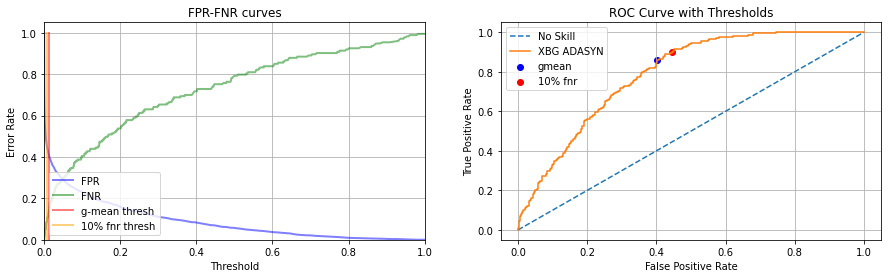

In [140]:
y_hat=xgb_clf.predict(xg_testX)
y_prob=xgb_clf.predict_proba(xg_testX)[:,1]

display_metrics(xg_testX,xg_testy,y_hat,y_prob)

### GridSearch with early stopping ###

best score: 0.8236625593169634
best params: {'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'reg_lambda': 1, 'scale_pos_weight': 35, 'subsample': 0.8}
AUC: 0.8196299982561132,  logloss: 0.6089951331868628
accuracy: 0.6036
recall: 0.9364
precision: 0.1249
-------------------
For a .5 threshold:
[[1583 1135]
 [  11  162]]
FPR: 0.4176  FNR: 0.0636
---------------------
G-Mean Threshold:
Best Threshold=0.633048, G-Mean=0.754
[[1817  901]
 [  27  146]]
FPR: 0.3315  FNR: 0.1561
---------------------
10% FNR Threshold:
Best Threshold: 0.5858
[[1674 1044]
 [  18  155]]
FPR: 0.3841  FNR: 0.104


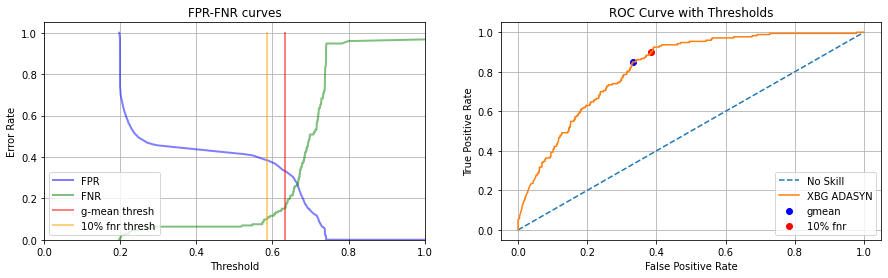

In [144]:
xgb_model=xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=123,
    n_estimators=5000
)

param_grid= {
    'max_depth': [6,10],
    'learning_rate': [.01],
    'gamma': [0,1],
    'reg_lambda': [0,1],
    'scale_pos_weight': [25,35],
    'subsample': [.8,1],
    'colsample_bytree': [1]
}

fit_params = {
    'early_stopping_rounds': 50, 
    'eval_metric': 'logloss',
    'eval_set': eval_set,
    'verbose': False
}

gs_xgb = GridSearchCV(xgb_model,param_grid,cv=3,scoring='roc_auc',
                   verbose=0)
    
gs_xgb.fit(xg_trainX, xg_trainy,**fit_params)
    
print('best score: {}'.format(gs_xgb.best_score_))
print('best params: {}'.format(gs_xgb.best_params_))
y_hat_test=gs_xgb.predict(xg_testX)
y_hat_prob=gs_xgb.predict_proba(xg_testX)[:,1]
display_metrics(xg_testX,xg_testy,y_hat_test,y_hat_prob)

best score: 0.8222553986057412
best params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.001, 'max_depth': 6, 'reg_lambda': 1, 'scale_pos_weight': 35, 'subsample': 1}
AUC: 0.8154372264543379,  logloss: 0.6176079186971358
accuracy: 0.6012
recall: 0.9364
precision: 0.1242
-------------------
For a .5 threshold:
[[1576 1142]
 [  11  162]]
FPR: 0.4202  FNR: 0.0636
---------------------
G-Mean Threshold:
Best Threshold=0.636508, G-Mean=0.753
[[1803  915]
 [  26  147]]
FPR: 0.3366  FNR: 0.1503
---------------------
10% FNR Threshold:
Best Threshold: 0.6002
[[1694 1024]
 [  18  155]]
FPR: 0.3767  FNR: 0.104


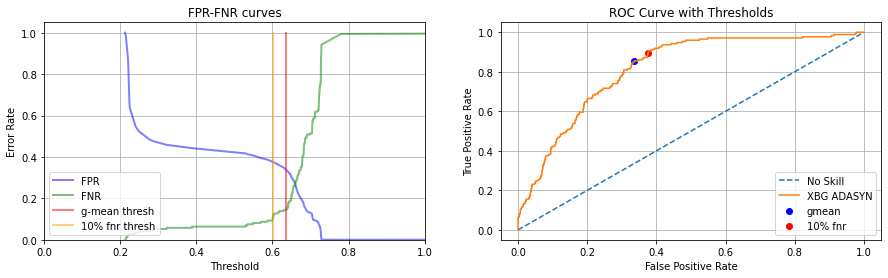

In [145]:
#Refine gridsearch

xgb_model=xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=123,
    n_estimators=5000
)

param_grid= {
    'max_depth': [6,8],
    'learning_rate': [.01,.001],
    'gamma': [1],
    'reg_lambda': [1],
    'scale_pos_weight': [30,32,35],
    'subsample': [1],
    'colsample_bytree': [.8]
}

fit_params = {
    'early_stopping_rounds': 50, 
    'eval_metric': 'logloss',
    'eval_set': eval_set,
    'verbose': False
}

gs_xgb1 = GridSearchCV(xgb_model,param_grid,cv=3,scoring='roc_auc',
                   verbose=0)
    
gs_xgb1.fit(xg_trainX, xg_trainy,**fit_params)
    
print('best score: {}'.format(gs_xgb1.best_score_))
print('best params: {}'.format(gs_xgb1.best_params_))
y_hat_test=gs_xgb1.predict(xg_testX)
y_hat_prob=gs_xgb1.predict_proba(xg_testX)[:,1]
display_metrics(xg_testX,xg_testy,y_hat_test,y_hat_prob)

These parameters performed slightly better, will a lower FPR with similar FNR.  Will still try to refine learning rate, scale_pos_weight, and tree depth.

best score: -0.23787891042901207
best params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'reg_lambda': 1, 'scale_pos_weight': 30, 'subsample': 1}
AUC: 0.7983556423245586,  logloss: 0.25409462682151174
accuracy: 0.9
recall: 0.2543
precision: 0.2157
-------------------
For a .5 threshold:
[[2558  160]
 [ 129   44]]
FPR: 0.0589  FNR: 0.7457
---------------------
G-Mean Threshold:
Best Threshold=0.011708, G-Mean=0.734
[[1612 1106]
 [  17  156]]
FPR: 0.4069  FNR: 0.0983
---------------------
10% FNR Threshold:
Best Threshold: 0.0118
[[1614 1104]
 [  18  155]]
FPR: 0.4062  FNR: 0.104


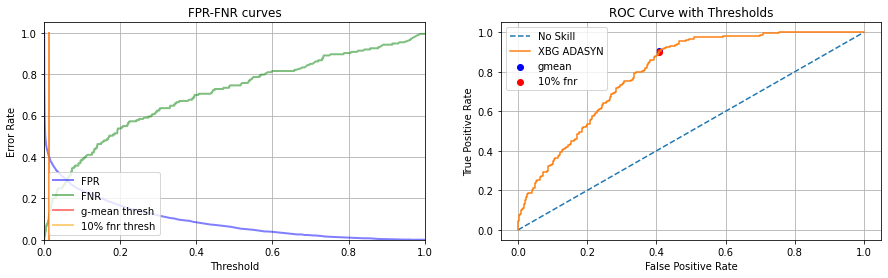

In [150]:
#Refine gridsearch- try neg_log_loss scoring

xgb_model=xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=123,
    n_estimators=5000
)

param_grid= {
    'max_depth': [6,8],
    'learning_rate': [.01,.001],
    'gamma': [1],
    'reg_lambda': [1],
    'scale_pos_weight': [30,32,35],
    'subsample': [1],
    'colsample_bytree': [.8]
}

fit_params = {
    'early_stopping_rounds': 50, 
    'eval_metric': 'logloss',
    'eval_set': eval_set,
    'verbose': False
}

gs_xgb1_5 = GridSearchCV(xgb_model,param_grid,cv=3,scoring='neg_log_loss',
                   verbose=0)
    
gs_xgb1_5.fit(xg_trainX, xg_trainy,**fit_params)
    
print('best score: {}'.format(gs_xgb1_5.best_score_))
print('best params: {}'.format(gs_xgb1_5.best_params_))
y_hat_test=gs_xgb1_5.predict(xg_testX)
y_hat_prob=gs_xgb1_5.predict_proba(xg_testX)[:,1]
display_metrics(xg_testX,xg_testy,y_hat_test,y_hat_prob)

AUC appears to result in better FNRs and pick models more suited the identifying fraud.

best score: 0.8222553986057412
best params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.001, 'max_depth': 6, 'reg_lambda': 1, 'scale_pos_weight': 35, 'subsample': 1}
AUC: 0.8222681587532484,  logloss: 0.6377699272581467
accuracy: 0.5908
recall: 0.9364
precision: 0.1214
-------------------
For a .5 threshold:
[[1546 1172]
 [  11  162]]
FPR: 0.4312  FNR: 0.0636
---------------------
G-Mean Threshold:
Best Threshold=0.610704, G-Mean=0.761
[[1841  877]
 [  26  147]]
FPR: 0.3227  FNR: 0.1503
---------------------
10% FNR Threshold:
Best Threshold: 0.6046
[[1710 1008]
 [  18  155]]
FPR: 0.3709  FNR: 0.104


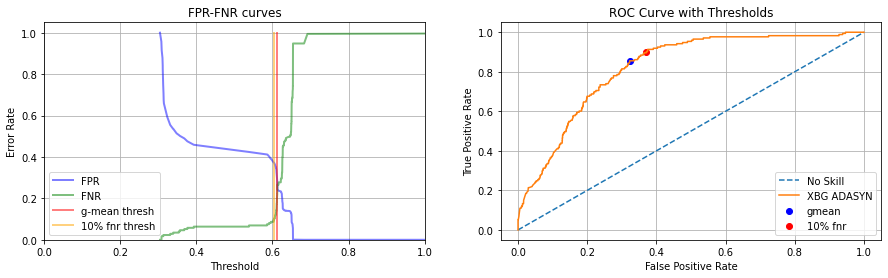

In [146]:
#Refine gridsearch- Try smaller learning rate

xgb_model=xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=123,
    n_estimators=5000
)

param_grid= {
    'max_depth': [5,6],
    'learning_rate': [.0001,.001],
    'gamma': [1],
    'reg_lambda': [1],
    'scale_pos_weight': [35,37],
    'subsample': [1],
    'colsample_bytree': [.8]
}

fit_params = {
    'early_stopping_rounds': 50, 
    'eval_metric': 'logloss',
    'eval_set': eval_set,
    'verbose': False
}

gs_xgb2 = GridSearchCV(xgb_model,param_grid,cv=3,scoring='roc_auc',
                   verbose=0)
    
gs_xgb2.fit(xg_trainX, xg_trainy,**fit_params)
    
print('best score: {}'.format(gs_xgb1.best_score_))
print('best params: {}'.format(gs_xgb1.best_params_))
y_hat_test=gs_xgb2.predict(xg_testX)
y_hat_prob=gs_xgb2.predict_proba(xg_testX)[:,1]
display_metrics(xg_testX,xg_testy,y_hat_test,y_hat_prob)

A smaller learning rate with smaller trees performed slightly better in terms of FPR with FNR set to 10%.  This is our best model so far.

best score: 0.8249382196191521
best params: {'colsample_bytree': 0.8, 'gamma': 3, 'learning_rate': 0.001, 'max_depth': 6, 'reg_lambda': 3, 'scale_pos_weight': 35, 'subsample': 1}
AUC: 0.8104054749539571,  logloss: 0.6157678469927902
accuracy: 0.615
recall: 0.9191
precision: 0.1264
-------------------
For a .5 threshold:
[[1619 1099]
 [  14  159]]
FPR: 0.4043  FNR: 0.0809
---------------------
G-Mean Threshold:
Best Threshold=0.602761, G-Mean=0.744
[[1737  981]
 [  24  149]]
FPR: 0.3609  FNR: 0.1387
---------------------
10% FNR Threshold:
Best Threshold: 0.532
[[1656 1062]
 [  18  155]]
FPR: 0.3907  FNR: 0.104


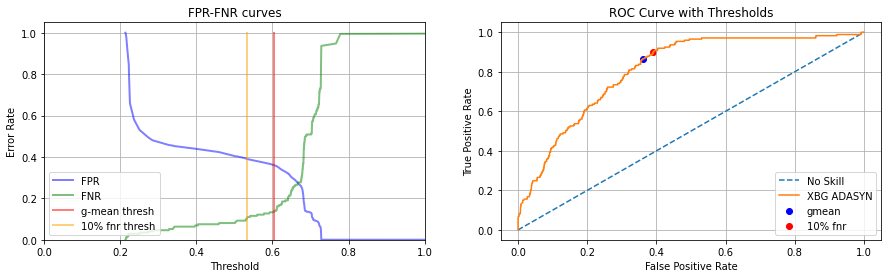

In [39]:
#Refine gridsearch- experiment with regularization

xgb_model=xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=123,
    n_estimators=5000
)

param_grid= {
    'max_depth': [6],
    'learning_rate': [.001],
    'gamma': [3,1],
    'reg_lambda': [3,1],
    'scale_pos_weight': [25,35],
    'subsample': [1],
    'colsample_bytree': [.8]
}

fit_params = {
    'early_stopping_rounds': 50, 
    'eval_metric': 'logloss',
    'eval_set': eval_set,
    'verbose': False
}

gs_xgb2 = GridSearchCV(xgb_model,param_grid,cv=3,scoring='roc_auc',
                   verbose=0)
    
gs_xgb2.fit(xg_trainX, xg_trainy,**fit_params)
    
print('best score: {}'.format(gs_xgb2.best_score_))
print('best params: {}'.format(gs_xgb2.best_params_))
y_hat_test=gs_xgb2.predict(xg_testX)
y_hat_prob=gs_xgb2.predict_proba(xg_testX)[:,1]
display_metrics(xg_testX,xg_testy,y_hat_test,y_hat_prob)

After refining our gridsearch, the best XGBoost model has a FPR of ~37% with FNR ~10% at a threshold of .6

## XGBoost with Oversampling ##

### Gridsearch with scaled data ###

AUC: [0.80418124 0.80753623 0.78311702 0.81565989 0.79075837]
accuracy: [0.94163424 0.93990489 0.93644617 0.93817553 0.93555363]
precision: [0.54545455 0.46666667 0.3        0.40909091 0.13333333]
recall: [0.13043478 0.05072464 0.04316547 0.0647482  0.01449275]


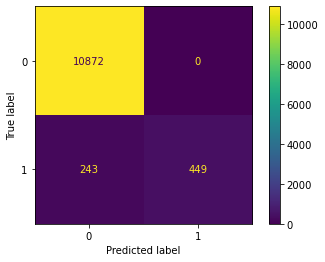

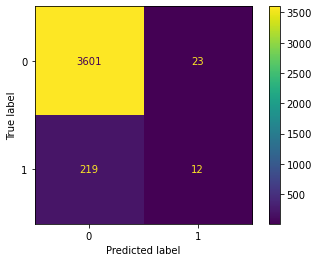

In [33]:
xgb_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

cv_results=cross_validate(xgb_pipe,X_train,y_train,
                         scoring=['roc_auc','accuracy',
                                  'precision','recall'])

print('AUC: {}'.format(cv_results['test_roc_auc']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))

xgb_pipe.fit(xg_trainX, xg_trainy)
plot_confusion_matrix(xgb_pipe,X_train,y_train)
plot_confusion_matrix(xgb_pipe,X_test,y_test)

In [309]:
#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [1,5,15,25,35],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.5,1]
}

gs_xgb=GridSearchCV(xgb_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_xgb.fit(X_train,y_train)
print('best score: {}'.format(gs_xgb.best_score_))
print('best params: {}'.format(gs_xgb.best_params_))
y_hat_test=gs_xgb.predict(X_test)
y_hat_prob=gs_xgb.predict_proba(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_hat_prob)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_xgb,X_train,y_train)
plot_confusion_matrix(gs_xgb,X_test,y_test)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_delta_step=0,
                                                      max_depth=6,
                                              

best score: 0.9609699479264696
best params: {'clf__colsample_bytree': 0.5, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 15, 'clf__subsample': 1}
log_loss: 0.5430451215666401
score: 0.6041504539559014
recall: 0.961038961038961
precision: 0.1276595744680851


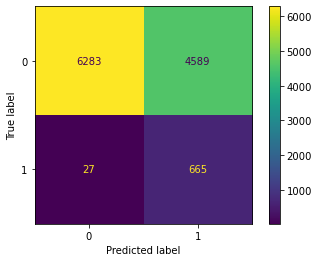

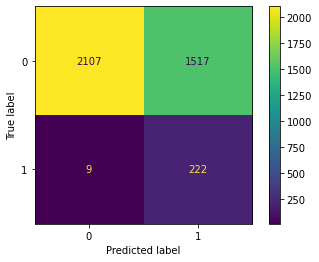

In [361]:
print('best score: {}'.format(gs_xgb.best_score_))
print('best params: {}'.format(gs_xgb.best_params_))
y_hat_test=gs_xgb.predict(X_test)
y_hat_prob=gs_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_xgb,X_train,y_train)
plot_confusion_matrix(gs_xgb,X_test,y_test)

best score: 0.8256358852673279
best params: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.0001, 'clf__max_depth': 6, 'clf__n_estimators': 1000, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 25, 'clf__subsample': 0.9}
log_loss: 0.6648854450802241
score: 0.6220492866407263
recall: 0.922077922077922
precision: 0.12893462469733658


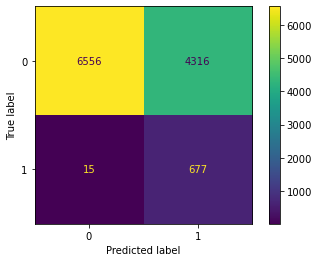

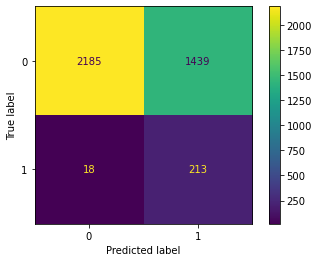

In [37]:
#Refine GridSearch

param_grid= {
    'clf__max_depth': [6,8],
    'clf__n_estimators': [800,1000],
    'clf__learning_rate': [.0001],
    'clf__gamma': [0],
    'clf__reg_lambda': [0],
    'clf__scale_pos_weight': [20,25,30],
    'clf__subsample': [.9],
    'clf__colsample_bytree': [.8]
}

gs_xgb_2=GridSearchCV(xgb_pipe,param_grid,cv=3,scoring='roc_auc',
                   verbose=0)
gs_xgb_2.fit(X_train,y_train)

print('best score: {}'.format(gs_xgb_2.best_score_))
print('best params: {}'.format(gs_xgb_2.best_params_))
y_hat_test=gs_xgb_2.predict(X_test)
y_hat_prob=gs_xgb_2.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_xgb_2,X_train,y_train)
plot_confusion_matrix(gs_xgb_2,X_test,y_test)

### XGBoost with RandomOverSample ###

AUC: [0.80888556 0.78062969 0.78227317 0.80565281 0.78899511]
accuracy: [0.89494163 0.88197147 0.88932123 0.90056204 0.89100346]
precision: [0.22797927 0.16080402 0.18378378 0.24861878 0.18333333]
recall: [0.31884058 0.23188406 0.24460432 0.32374101 0.23913043]


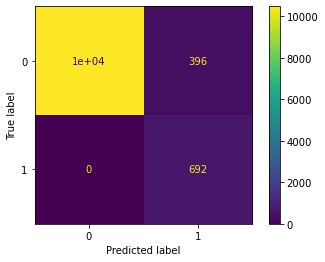

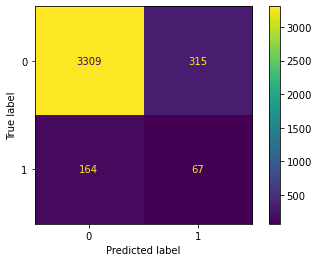

In [311]:
xgb_ros_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('ros',RandomOverSampler(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

cv_results=cross_validate(xgb_ros_pipe,X_train,y_train,
                         scoring=['roc_auc','accuracy',
                                  'precision','recall'])

print('AUC: {}'.format(cv_results['test_roc_auc']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))

xgb_ros_pipe.fit(X_train,y_train)
plot_confusion_matrix(xgb_ros_pipe,X_train,y_train)
plot_confusion_matrix(xgb_ros_pipe,X_test,y_test)

In [312]:
#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [1,3,5],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.5,1]
}

gs_ros_xgb=GridSearchCV(xgb_ros_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_ros_xgb.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ros',
                                        RandomOverSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_del

best score: 0.9667419536984755
best params: {'clf__colsample_bytree': 1, 'clf__gamma': 0, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__reg_lambda': 10, 'clf__scale_pos_weight': 5, 'clf__subsample': 1}
log_loss: 1.0369599477734643
score: 0.5735408560311284
recall: 0.961038961038961
precision: 0.11954765751211632


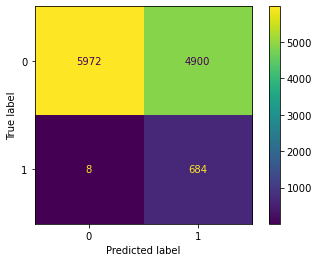

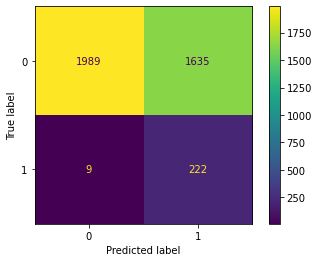

In [313]:
print('best score: {}'.format(gs_ros_xgb.best_score_))
print('best params: {}'.format(gs_ros_xgb.best_params_))
y_hat_test=gs_ros_xgb.predict(X_test)
y_hat_prob=gs_ros_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ros_xgb,X_train,y_train)
plot_confusion_matrix(gs_ros_xgb,X_test,y_test)

In [314]:
#Perform GridSearchCV to find max f1 score

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [1,3,5],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.5,1]
}

gs_ros_xgb=GridSearchCV(xgb_ros_pipe,param_grid,cv=3,scoring='f1',
                   verbose=0)
gs_ros_xgb.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ros',
                                        RandomOverSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_del

best score: 0.25820512767409187
best params: {'clf__colsample_bytree': 1, 'clf__gamma': 1, 'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__reg_lambda': 10, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}
log_loss: 0.3446913610413023
score: 0.7880674448767834
f1 score:0.24000000000000002
recall: 0.5584415584415584
precision: 0.1528436018957346


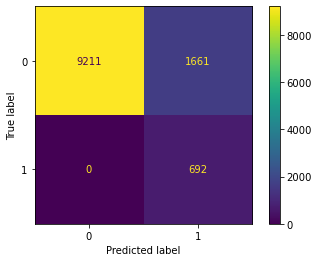

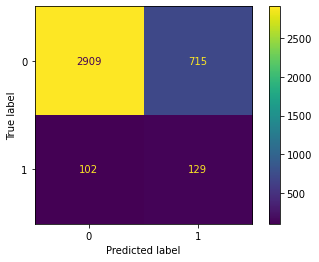

In [315]:
print('best score: {}'.format(gs_ros_xgb.best_score_))
print('best params: {}'.format(gs_ros_xgb.best_params_))
y_hat_test=gs_ros_xgb.predict(X_test)
y_hat_prob=gs_ros_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ros_xgb,X_train,y_train)
plot_confusion_matrix(gs_ros_xgb,X_test,y_test)

### XGBoost with SMOTE ###

best score: 0.9624129493694711
best params: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 5, 'clf__subsample': 1}
log_loss: 0.7238082351774248
score: 0.5987029831387808
f1 score:0.22300351582119537
recall: 0.961038961038961
precision: 0.12613636363636363


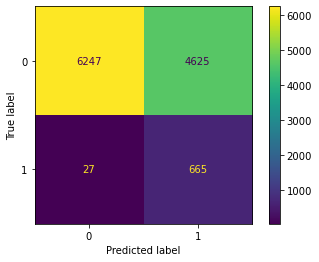

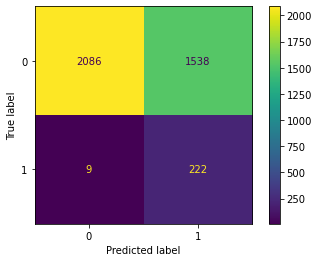

In [316]:
xgb_smote_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('smote',SMOTE(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [5,10,15],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.8,1]
}

gs_smote_xgb=GridSearchCV(xgb_smote_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_smote_xgb.fit(X_train,y_train)

print('best score: {}'.format(gs_smote_xgb.best_score_))
print('best params: {}'.format(gs_smote_xgb.best_params_))
y_hat_test=gs_smote_xgb.predict(X_test)
y_hat_prob=gs_smote_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_smote_xgb,X_train,y_train)
plot_confusion_matrix(gs_smote_xgb,X_test,y_test)

best score: 0.9681912290607944
best params: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 15, 'clf__subsample': 0.8}
log_loss: 0.8421340568520216
score: 0.5782101167315176
f1 score:0.21600771456123435
recall: 0.9696969696969697
precision: 0.12154096581660337


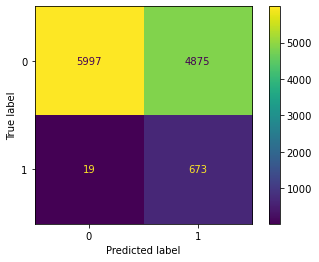

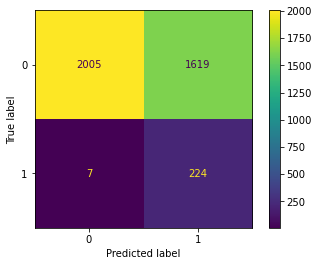

In [322]:
xgb_smote_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('smote',SMOTE(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [5,10,15],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.8,1]
}

gs_smote_xgb=GridSearchCV(xgb_smote_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_smote_xgb.fit(X_train,y_train)

print('best score: {}'.format(gs_smote_xgb.best_score_))
print('best params: {}'.format(gs_smote_xgb.best_params_))
y_hat_test=gs_smote_xgb.predict(X_test)
y_hat_prob=gs_smote_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_smote_xgb,X_train,y_train)
plot_confusion_matrix(gs_smote_xgb,X_test,y_test)

### XGBoost with ADASYN ###

best score: 0.8025905660335547
best params: {'clf__colsample_bytree': 0.8, 'clf__gamma': 1, 'clf__learning_rate': 0.0001, 'clf__max_depth': 10, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}
log_loss: 0.6332011051369703
score: 0.9237354085603113
f1 score:0.11976047904191618
recall: 0.08658008658008658
precision: 0.1941747572815534


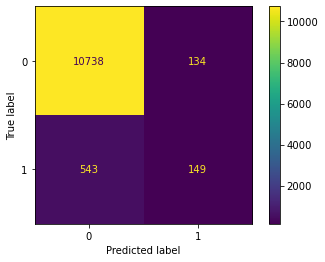

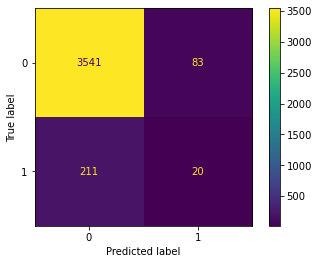

In [39]:
xgb_ada_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('adasyn',ADASYN(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic',
                             n_estimators=1000,
                             random_state=123))
])

#Perform GridSearchCV to find max roc_auc

param_grid= {
    'clf__max_depth': [6,10],
    'clf__learning_rate': [.0001],
    'clf__gamma': [0,1],
    'clf__reg_lambda': [0,1],
    #'clf__scale_pos_weight': [1,5],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.8,1]
}

gs_ada_xgb=GridSearchCV(xgb_ada_pipe,param_grid,cv=3,scoring='roc_auc',
                   verbose=0)
gs_ada_xgb.fit(X_train,y_train)

print('best score: {}'.format(gs_ada_xgb.best_score_))
print('best params: {}'.format(gs_ada_xgb.best_params_))
y_hat_test=gs_ada_xgb.predict(X_test)
y_hat_prob=gs_ada_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ada_xgb,X_train,y_train)
plot_confusion_matrix(gs_ada_xgb,X_test,y_test)

best score: 0.5419725202333897
best params: {'clf__colsample_bytree': 1, 'clf__gamma': 0, 'clf__learning_rate': 0.0001, 'clf__max_depth': 6, 'clf__reg_lambda': 0, 'clf__subsample': 1}
log_loss: 0.6459722650808738
score: 0.7348897535667964
f1 score:0.22340425531914895
recall: 0.6363636363636364
precision: 0.13548387096774195


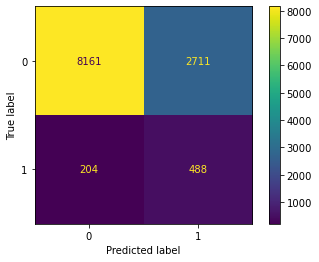

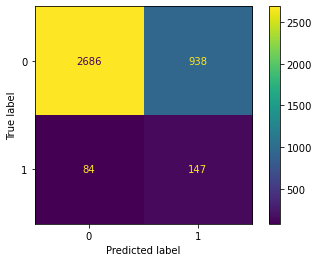

In [40]:
xgb_ada_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('adasyn',ADASYN(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic',
                             n_estimators=1000,
                             random_state=123))
])

#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [6,10],
    'clf__learning_rate': [.0001],
    'clf__gamma': [0,1],
    'clf__reg_lambda': [0,1],
    #'clf__scale_pos_weight': [1,5],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.8,1]
}

gs_ada_xgb=GridSearchCV(xgb_ada_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_ada_xgb.fit(X_train,y_train)

print('best score: {}'.format(gs_ada_xgb.best_score_))
print('best params: {}'.format(gs_ada_xgb.best_params_))
y_hat_test=gs_ada_xgb.predict(X_test)
y_hat_prob=gs_ada_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ada_xgb,X_train,y_train)
plot_confusion_matrix(gs_ada_xgb,X_test,y_test)

## Best XGBoost Model ##

In [40]:
xgb_best=xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=123,
    n_estimators=5000, 
    scale_pos_weight=35, 
    learning_rate=.001,
    colsample_bytree=.8,
    max_depth=6,
    reg_lambda=1,
    gamma=1,
    subsample=1
)

xgb_best.fit(
    xg_trainX, xg_trainy, 
    early_stopping_rounds=50, 
    eval_metric='logloss',
    eval_set=eval_set,
    verbose=True
)



[0]	validation_0-logloss:0.69284
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.69256
[2]	validation_0-logloss:0.69226
[3]	validation_0-logloss:0.69223
[4]	validation_0-logloss:0.69193
[5]	validation_0-logloss:0.69163
[6]	validation_0-logloss:0.69136
[7]	validation_0-logloss:0.69107
[8]	validation_0-logloss:0.69104
[9]	validation_0-logloss:0.69075
[10]	validation_0-logloss:0.69046
[11]	validation_0-logloss:0.69017
[12]	validation_0-logloss:0.68988
[13]	validation_0-logloss:0.68959
[14]	validation_0-logloss:0.68931
[15]	validation_0-logloss:0.68905
[16]	validation_0-logloss:0.68877
[17]	validation_0-logloss:0.68849
[18]	validation_0-logloss:0.68844
[19]	validation_0-logloss:0.68816
[20]	validation_0-logloss:0.68789
[21]	validation_0-logloss:0.68760
[22]	validation_0-logloss:0.68759
[23]	validation_0-logloss:0.68731
[24]	validation_0-logloss:0.68705
[25]	validation_0-logloss:0.68678
[26]	validation_0-logloss:0.68652
[27]	validation_0-loglos

[236]	validation_0-logloss:0.64488
[237]	validation_0-logloss:0.64474
[238]	validation_0-logloss:0.64462
[239]	validation_0-logloss:0.64449
[240]	validation_0-logloss:0.64435
[241]	validation_0-logloss:0.64421
[242]	validation_0-logloss:0.64408
[243]	validation_0-logloss:0.64394
[244]	validation_0-logloss:0.64380
[245]	validation_0-logloss:0.64367
[246]	validation_0-logloss:0.64353
[247]	validation_0-logloss:0.64353
[248]	validation_0-logloss:0.64339
[249]	validation_0-logloss:0.64324
[250]	validation_0-logloss:0.64309
[251]	validation_0-logloss:0.64294
[252]	validation_0-logloss:0.64280
[253]	validation_0-logloss:0.64268
[254]	validation_0-logloss:0.64253
[255]	validation_0-logloss:0.64240
[256]	validation_0-logloss:0.64226
[257]	validation_0-logloss:0.64213
[258]	validation_0-logloss:0.64199
[259]	validation_0-logloss:0.64186
[260]	validation_0-logloss:0.64172
[261]	validation_0-logloss:0.64160
[262]	validation_0-logloss:0.64146
[263]	validation_0-logloss:0.64134
[264]	validation_0-l

[471]	validation_0-logloss:0.62275
[472]	validation_0-logloss:0.62268
[473]	validation_0-logloss:0.62262
[474]	validation_0-logloss:0.62255
[475]	validation_0-logloss:0.62250
[476]	validation_0-logloss:0.62245
[477]	validation_0-logloss:0.62238
[478]	validation_0-logloss:0.62234
[479]	validation_0-logloss:0.62227
[480]	validation_0-logloss:0.62221
[481]	validation_0-logloss:0.62215
[482]	validation_0-logloss:0.62209
[483]	validation_0-logloss:0.62202
[484]	validation_0-logloss:0.62195
[485]	validation_0-logloss:0.62188
[486]	validation_0-logloss:0.62181
[487]	validation_0-logloss:0.62175
[488]	validation_0-logloss:0.62168
[489]	validation_0-logloss:0.62161
[490]	validation_0-logloss:0.62156
[491]	validation_0-logloss:0.62150
[492]	validation_0-logloss:0.62144
[493]	validation_0-logloss:0.62138
[494]	validation_0-logloss:0.62132
[495]	validation_0-logloss:0.62127
[496]	validation_0-logloss:0.62129
[497]	validation_0-logloss:0.62123
[498]	validation_0-logloss:0.62117
[499]	validation_0-l

[706]	validation_0-logloss:0.61388
[707]	validation_0-logloss:0.61386
[708]	validation_0-logloss:0.61385
[709]	validation_0-logloss:0.61384
[710]	validation_0-logloss:0.61383
[711]	validation_0-logloss:0.61381
[712]	validation_0-logloss:0.61379
[713]	validation_0-logloss:0.61377
[714]	validation_0-logloss:0.61375
[715]	validation_0-logloss:0.61372
[716]	validation_0-logloss:0.61371
[717]	validation_0-logloss:0.61368
[718]	validation_0-logloss:0.61366
[719]	validation_0-logloss:0.61364
[720]	validation_0-logloss:0.61364
[721]	validation_0-logloss:0.61362
[722]	validation_0-logloss:0.61362
[723]	validation_0-logloss:0.61361
[724]	validation_0-logloss:0.61359
[725]	validation_0-logloss:0.61357
[726]	validation_0-logloss:0.61356
[727]	validation_0-logloss:0.61355
[728]	validation_0-logloss:0.61353
[729]	validation_0-logloss:0.61350
[730]	validation_0-logloss:0.61348
[731]	validation_0-logloss:0.61346
[732]	validation_0-logloss:0.61345
[733]	validation_0-logloss:0.61342
[734]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=0, num_parallel_tree=1,
              random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=35,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

AUC: 0.8112327578506808,  logloss: 0.612395459869171
accuracy: 0.6154
recall: 0.9133
precision: 0.1259
-------------------
For a .5 threshold:
[[1621 1097]
 [  15  158]]
FPR: 0.4036  FNR: 0.0867
---------------------
G-Mean Threshold:
Best Threshold=0.609760, G-Mean=0.748
[[1753  965]
 [  24  149]]
FPR: 0.355  FNR: 0.1387
---------------------
10% FNR Threshold:
Best Threshold: 0.5285
[[1662 1056]
 [  18  155]]
FPR: 0.3885  FNR: 0.104


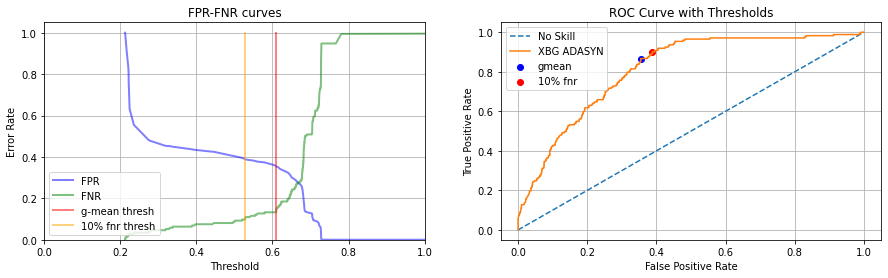

In [43]:
y_hat_test=xgb_best.predict(xg_testX)
y_hat_prob=xgb_best.predict_proba(xg_testX)[:,1]
display_metrics(xg_testX,xg_testy,y_hat_test,y_hat_prob)

In [47]:
#Best threshold is .5285; predict with test data
best_thresh=.5285

y_hat_prob=xgb_best.predict_proba(X_test)[:,1]
y_hat_test=thresh_pred(y_hat_prob,best_thresh)
fpr,tpr,thresholds=roc_curve(y_test,y_hat_prob)
print('AUC: {},  logloss: {}'.format(auc(fpr,tpr),log_loss(y_test,y_hat_prob)))
print('accuracy: {}'.format(round(accuracy_score(y_test,y_hat_test),4)))
print('recall: {}'.format(round(recall_score(y_test,y_hat_test),4)))
print('precision: {}'.format(round(precision_score(y_test,y_hat_test),4)))
print('-------------------')
print(confusion_matrix(y_test,y_hat_test))
fpr,fnr=calc_fpr_fnr(y_test,y_hat_test)
print('FPR: {}  FNR: {}'.format(round(fpr,4),round(fnr,4)))

AUC: 0.8045449767304071,  logloss: 0.6040263190459648
accuracy: 0.6329
recall: 0.8831
precision: 0.1281
-------------------
[[2236 1388]
 [  27  204]]
FPR: 0.383  FNR: 0.1169


# CATBoost #

## Define Functions for Model Comparison ##

In [36]:
#Function to display all desired metrics and threshold comparisons

def display_metrics_cat(model,val_pool,y_test):
    """
    Takes in model, val_pool, and test set from val_pool and displays metrics

    """

    #get predictions
    y_hat=model.predict(val_pool)
    y_prob=model.predict_proba(val_pool)[:,1]
    
    #Print Metrics
    #curve = get_roc_curve(cat_model,val_pool)
    fpr,tpr,thresholds=roc_curve(y_test,y_prob)
    fnr=1-tpr
    #thresholds, fpr = get_fpr_curve(curve = curve)
    #thresholds, fnr = get_fnr_curve(curve = curve)
    print('AUC: {},  logloss: {}'.format(auc(fpr,tpr),log_loss(y_test,y_prob)))
    print('accuracy: {}'.format(round(accuracy_score(y_test,y_hat),4)))
    print('recall: {}'.format(round(recall_score(y_test,y_hat),4)))
    print('precision: {}'.format(round(precision_score(y_test,y_hat),4)))
    print('-------------------')
    print('For a .5 threshold:')
    print(confusion_matrix(y_test,y_hat))
    fpr_5,fnr_5=calc_fpr_fnr(y_test,y_hat)
    print('FPR: {}  FNR: {}'.format(round(fpr_5,4),round(fnr_5,4)))

    #Calculate gmean and corresponding threshold
    gmeans=np.sqrt(tpr*(1-fpr))
    ix=np.argmax(gmeans)
    g_thresh=thresholds[ix]
    
    #Calculate threshold corresponding to 10% FNR
    thresh_10, idx = select_threshold_fnr(fnr, thresholds, .1)
    thresh_5, idx5 = select_threshold_fnr(fnr, thresholds, .05)
    #thresh10_cat=select_threshold(model,val_pool,FNR=.1)
    
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    ax1=axes[0]
    ax2=axes[1]
    
    #Graph FPR/FNR vs Threshold
    style = {'alpha':0.5, 'lw':2}

    ax1.plot(thresholds, fpr, color='blue', label='FPR', **style)
    ax1.plot(thresholds, fnr, color='green', label='FNR', **style)
    ax1.plot([g_thresh,g_thresh],[0,1],color='red', label='g-mean thresh', 
             **style)
    ax1.plot([thresh_10,thresh_10],[0,1],color='orange', 
             label='10% fnr thresh', 
             **style)
    ax1.set_xlim([0.0,1.0])
    ax1.set_ylim([0.0,1.05])
    #ax1.set_xticks(fontsize=12)
    #ax1.set_yticks(fontsize=12)
    ax1.grid(True)
    ax1.set_xlabel('Threshold', fontsize=10)
    ax1.set_ylabel('Error Rate', fontsize=10)
    ax1.set_title('FPR-FNR curves', fontsize=12)
    ax1.legend(loc='lower left', fontsize=10)
    
    #Graph ROC Curve with threshold
    # plot the roc curve for the model
    ax2.plot([0,1], [0,1], linestyle='--', label='No Skill')
    ax2.plot(fpr, tpr, label='XBG ADASYN')
    ax2.scatter(fpr[ix], tpr[ix], marker='o', color='blue', label='gmean')
    ax2.scatter(fpr[idx], tpr[idx], marker='o', color='red', label='10% fnr')
    # axis labels
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.grid(True)
    ax2.set_title('ROC Curve with Thresholds', fontsize=12)
    ax2.legend()

    #print outcomes with alternative thresholds
    print('---------------------')
    print('G-Mean Threshold:')
    print('Best Threshold=%f, G-Mean=%.3f' % (g_thresh, gmeans[ix]))
    y_hat_g=thresh_pred(y_prob,g_thresh)
    print(confusion_matrix(y_test,y_hat_g))
    g_fpr,g_fnr=calc_fpr_fnr(y_test,y_hat_g)
    print('FPR: {}  FNR: {}'.format(round(g_fpr,4),round(g_fnr,4)))
    print('---------------------')
    print('10% FNR Threshold:')
    print('Best Threshold: {}'.format(round(thresh_10,4)))
    y_hat_10=thresh_pred(y_prob,thresh_10)
    print(confusion_matrix(y_test,y_hat_10))
    ten_fpr,ten_fnr=calc_fpr_fnr(y_test,y_hat_10)
    print('FPR: {}  FNR: {}'.format(round(ten_fpr,4),round(ten_fnr,4)))
    print('---------------------')
    print('5% FNR Threshold:')
    print('Best Threshold: {}'.format(round(thresh_5,4)))
    y_hat_5=thresh_pred(y_prob,thresh_5)
    print(confusion_matrix(y_test,y_hat_5))
    five_fpr,five_fnr=calc_fpr_fnr(y_test,y_hat_5)
    print('FPR: {}  FNR: {}'.format(round(five_fpr,4),round(five_fnr,4)))

In [37]:
#Catboost can handle categorical variables
#We'll use a diff version of X_train that hasn't been ohe'd
#X, y are before ohe

#get list of categorical features in X
dtypes=X.dtypes.reset_index()
cat_features=dtypes[dtypes[0]=='object']['index'].to_list()

#Split into test and train
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y ,random_state=42, stratify=y
)

#Split training set into train and validation for catboost training

train_X, val_X, train_y, val_y = train_test_split(
    X_train_cat, y_train_cat, random_state=42, stratify=y_train_cat
)

In [38]:
#create train_pool and validation_pool

train_pool = catboost.Pool(
    data = train_X,
    label = train_y,
    cat_features = cat_features
)

val_pool = catboost.Pool(
    data = val_X,
    label = val_y,
    cat_features=cat_features
)

## Build CatBoost Models ##

### Baseline Catboost ###

Catboost default iterations is 1000 and it automatically calculates a learning rate based on the data set and number of iterations. It will revert back to iteration with the best loss fn score for model output. 

It uses log-loss for loss function and calculates log loss as well as any other metrics defined in 'custom_loss' for each iteration (can be seen on the graph). 

The scale_pos_weight parameter is used for class imbalances and it is set here to the recommended amount of (sum_pos/sum_neg) (96/4).  We will work on tuning this hyperparameter as well as a few others later on.

In [155]:
cat_model = catboost.CatBoostClassifier(
    verbose=50,
    #iterations=500,
    #learning_rate=.05,
    custom_loss=['AUC','Recall','Accuracy'],
    train_dir='first',
    scale_pos_weight=24
)

cat_model.fit(train_pool, eval_set = val_pool, verbose=200,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.05403
0:	learn: 0.6645234	test: 0.6629554	best: 0.6629554 (0)	total: 12.8ms	remaining: 12.8s
200:	learn: 0.3561671	test: 0.4817379	best: 0.4690717 (167)	total: 1.43s	remaining: 5.7s
400:	learn: 0.2248780	test: 0.5667851	best: 0.4690717 (167)	total: 2.97s	remaining: 4.43s
600:	learn: 0.1532430	test: 0.6833042	best: 0.4690717 (167)	total: 4.54s	remaining: 3.02s
800:	learn: 0.1108092	test: 0.8063034	best: 0.4690717 (167)	total: 6.28s	remaining: 1.56s
999:	learn: 0.0821189	test: 0.9274641	best: 0.4690717 (167)	total: 8.06s	remaining: 0us

bestTest = 0.4690717093
bestIteration = 167

Shrink model to first 168 iterations.


AUC: 0.8244522706682489,  logloss: 0.6121886823284021
accuracy: 0.6008
recall: 0.9422
precision: 0.1247
-------------------
For a .5 threshold:
[[1574 1144]
 [  10  163]]
FPR: 0.4209  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.645216, G-Mean=0.749
[[1722  996]
 [  20  153]]
FPR: 0.3664  FNR: 0.1156
---------------------
10% FNR Threshold:
Best Threshold: 0.6221
[[1675 1043]
 [  18  155]]
FPR: 0.3837  FNR: 0.104


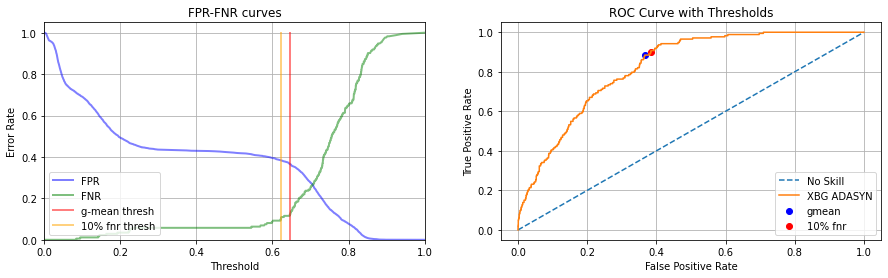

In [157]:
display_metrics_cat(cat_model,val_pool,val_y)

### Catboost built-in grid_search ###

In [59]:
clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    scale_pos_weight=24,
    verbose=False
)

param_grid = {
    'l2_leaf_reg': [1,5],
    'depth': [4,6]
}

gs_result=clf.grid_search(
    param_grid,
    train_pool,
    stratified=True,
    plot=True,
    cv=3,
    verbose=200
)
gs_result['params']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4619986624
bestIteration = 267

0:	loss: 0.4619987	best: 0.4619987 (0)	total: 4.69s	remaining: 14.1s

bestTest = 0.4584361725
bestIteration = 277


bestTest = 0.4641567886
bestIteration = 176


bestTest = 0.4650149914
bestIteration = 153

3:	loss: 0.4650150	best: 0.4584362 (1)	total: 23.3s	remaining: 0us
Estimating final quality...


{'depth': 4, 'l2_leaf_reg': 5}

AUC: 0.807411093672243,  logloss: 0.5351196021036813
accuracy: 0.6579
recall: 0.815
precision: 0.1284
-------------------
For a .5 threshold:
[[1761  957]
 [  32  141]]
FPR: 0.3521  FNR: 0.185
---------------------
G-Mean Threshold:
Best Threshold=0.313214, G-Mean=0.739
[[1594 1124]
 [  13  160]]
FPR: 0.4135  FNR: 0.0751
---------------------
10% FNR Threshold:
Best Threshold: 0.3818
[[1632 1086]
 [  18  155]]
FPR: 0.3996  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.2186
[[1496 1222]
 [   9  164]]
FPR: 0.4496  FNR: 0.052


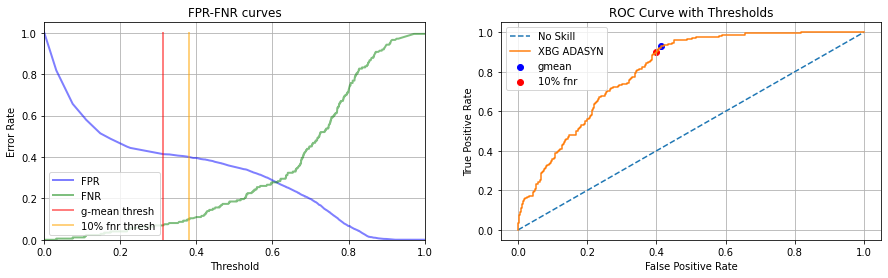

In [60]:
display_metrics_cat(clf,val_pool,val_y)

### GridSearch for roc_auc ###

best score: 0.8137656471308808
best params: {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'scale_pos_weight': 20}
AUC: 0.8228168450960626,  logloss: 0.5862809940083122
accuracy: 0.597
recall: 0.9422
precision: 0.1237
-------------------
For a .5 threshold:
[[1563 1155]
 [  10  163]]
FPR: 0.4249  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.639070, G-Mean=0.756
[[1755  963]
 [  21  152]]
FPR: 0.3543  FNR: 0.1214
---------------------
10% FNR Threshold:
Best Threshold: 0.613
[[1676 1042]
 [  18  155]]
FPR: 0.3834  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.2113
[[1475 1243]
 [   9  164]]
FPR: 0.4573  FNR: 0.052


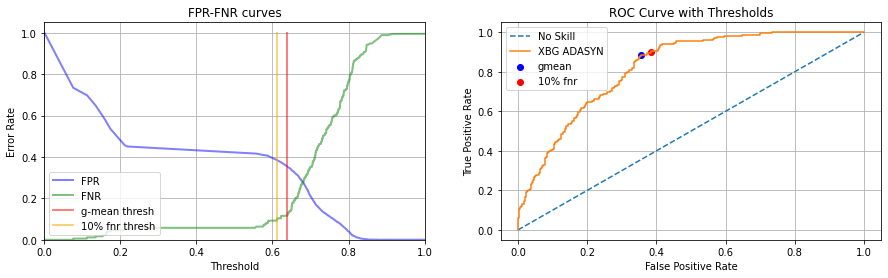

In [52]:
#GridSearch with cat_model for roc_auc

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    verbose=False,
)

param_grid = {
    'scale_pos_weight': [20,25,30],
    #'random_strength': [0,1],
    'l2_leaf_reg': [1],
    'depth': [4,6,10],
    'iterations': [1000],
    #'eval_metric': ['Logloss','AUC'],
    'learning_rate': [.01]
}

cat_gs = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='roc_auc')
cat_gs.fit(train_X,train_y)

print('best score: {}'.format(cat_gs.best_score_))
print('best params: {}'.format(cat_gs.best_params_))

display_metrics_cat(cat_gs,val_pool,val_y)

best score: 0.8156718713890555
best params: {'depth': 4, 'eval_metric': 'Logloss', 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'scale_pos_weight': 25}
AUC: 0.8249499164210338,  logloss: 0.6643076585476236
accuracy: 0.5918
recall: 0.9422
precision: 0.1223
-------------------
For a .5 threshold:
[[1548 1170]
 [  10  163]]
FPR: 0.4305  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.669730, G-Mean=0.747
[[1673 1045]
 [  17  156]]
FPR: 0.3845  FNR: 0.0983
---------------------
10% FNR Threshold:
Best Threshold: 0.6725
[[1683 1035]
 [  18  155]]
FPR: 0.3808  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.2367
[[1443 1275]
 [   9  164]]
FPR: 0.4691  FNR: 0.052


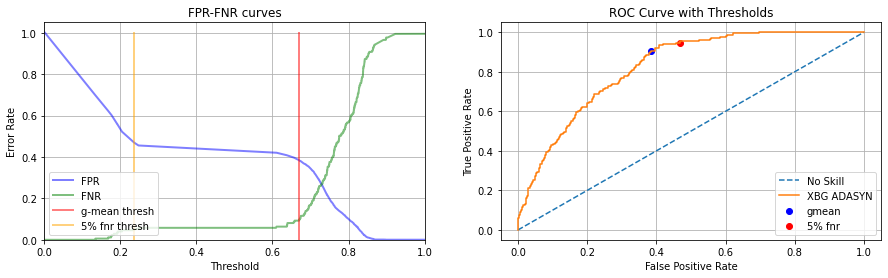

In [220]:
#GridSearch with cat_model for roc_auc, add l2 regularization parameter, test diff eval metric

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    verbose=False,
)

param_grid = {
    'scale_pos_weight': [20,25,30],
    #'random_strength': [0,1],
    'l2_leaf_reg': [1,5],
    'depth': [4,6],
    'iterations': [1000],
    'eval_metric': ['Logloss','AUC'],
    'learning_rate': [.01]
}

cat_gs = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='roc_auc')
cat_gs.fit(train_X,train_y)

print('best score: {}'.format(cat_gs.best_score_))
print('best params: {}'.format(cat_gs.best_params_))

display_metrics_cat(cat_gs,val_pool,val_y)

best score: 0.8178651989661446
best params: {'depth': 4, 'eval_metric': 'Logloss', 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'scale_pos_weight': 22}
AUC: 0.8243076556631662,  logloss: 0.6233457838292038
accuracy: 0.5929
recall: 0.9422
precision: 0.1226
-------------------
For a .5 threshold:
[[1551 1167]
 [  10  163]]
FPR: 0.4294  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.663134, G-Mean=0.755
[[1731  987]
 [  19  154]]
FPR: 0.3631  FNR: 0.1098
---------------------
10% FNR Threshold:
Best Threshold: 0.6522
[[1699 1019]
 [  18  155]]
FPR: 0.3749  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.2148
[[1423 1295]
 [   9  164]]
FPR: 0.4765  FNR: 0.052


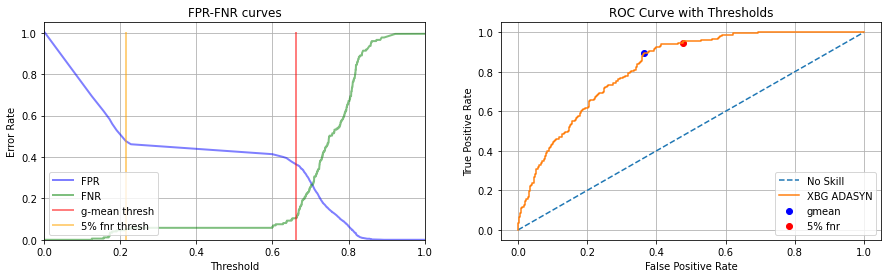

In [221]:
#GridSearch with cat_model for roc_auc; refine weighting and l2

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    verbose=False,
)

param_grid = {
    'scale_pos_weight': [22,25,28],
    #'random_strength': [0,1],
    'l2_leaf_reg': [5,8],
    'depth': [4,6],
    'iterations': [1000],
    'eval_metric': ['Logloss'],
    'learning_rate': [.01]
}

cat_gs1 = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='roc_auc')
cat_gs1.fit(train_X,train_y)

print('best score: {}'.format(cat_gs1.best_score_))
print('best params: {}'.format(cat_gs1.best_params_))

display_metrics_cat(cat_gs1,val_pool,val_y)

best score: 0.8185251821511056
best params: {'depth': 6, 'learning_rate': 0.001}
AUC: 0.826232311245518,  logloss: 0.6286816610148134
accuracy: 0.5901
recall: 0.9422
precision: 0.1218
-------------------
For a .5 threshold:
[[1543 1175]
 [  10  163]]
FPR: 0.4323  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.692498, G-Mean=0.753
[[1852  866]
 [  30  143]]
FPR: 0.3186  FNR: 0.1734
---------------------
10% FNR Threshold:
Best Threshold: 0.671
[[1698 1020]
 [  18  155]]
FPR: 0.3753  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.2105
[[1424 1294]
 [   9  164]]
FPR: 0.4761  FNR: 0.052


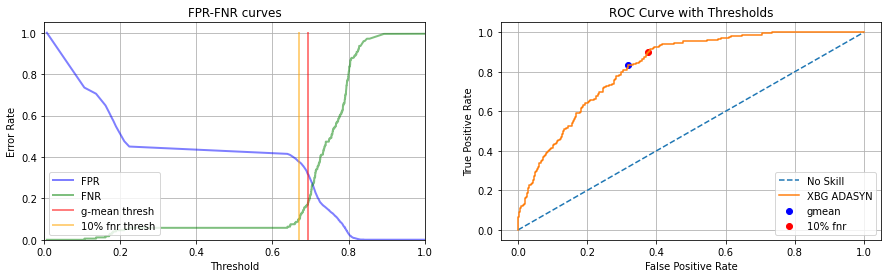

In [62]:
#GridSearch with cat_model for roc_auc; look at higher regularization, lower weighting

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    iterations=5000,
    #learning_rate=.01,
    scale_pos_weight=22,
    l2_leaf_reg=5,
    verbose=False
)

param_grid = {
    #'scale_pos_weight': [15,20,22],
    #'random_strength': [0,1],
    #'l2_leaf_reg': [5,8],
    'depth': [4,6],
    'learning_rate': [.001,.01]
}

cat_gs2 = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='roc_auc')
cat_gs2.fit(train_X,train_y)

print('best score: {}'.format(cat_gs2.best_score_))
print('best params: {}'.format(cat_gs2.best_params_))

display_metrics_cat(cat_gs2,val_pool,val_y)

### GridSearch for f1_score ###

best score: 0.2281955878854245
best params: {'depth': 4, 'l2_leaf_reg': 1, 'random_strength': 0, 'scale_pos_weight': 22}
AUC: 0.8173236015941677,  logloss: 0.5676344424731149
accuracy: 0.6278
recall: 0.8844
precision: 0.1266
-------------------
For a .5 threshold:
[[1662 1056]
 [  20  153]]
FPR: 0.3885  FNR: 0.1156
---------------------
G-Mean Threshold:
Best Threshold=0.573917, G-Mean=0.740
[[1765  953]
 [  28  145]]
FPR: 0.3506  FNR: 0.1618
---------------------
10% FNR Threshold:
Best Threshold: 0.4828
[[1647 1071]
 [  18  155]]
FPR: 0.394  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.2145
[[1362 1356]
 [   9  164]]
FPR: 0.4989  FNR: 0.052


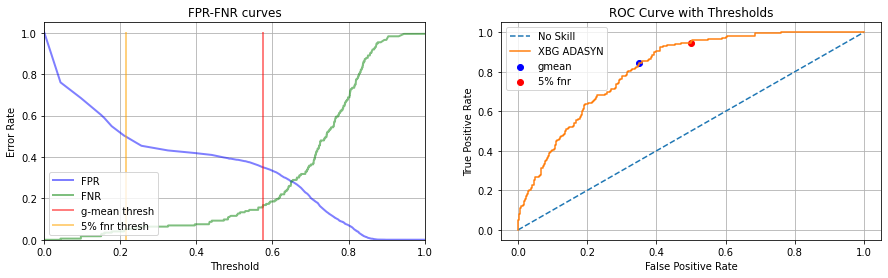

In [223]:
#GridSearch with cat_model for f1 score

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    iterations=1000,
    learning_rate=.01,
    verbose=False
)

param_grid = {
    'scale_pos_weight': [22,25],
    'random_strength': [0,1],
    'l2_leaf_reg': [1,5,10],
    'depth': [4],
}

cat_gsf = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='f1')
cat_gsf.fit(train_X,train_y)

print('best score: {}'.format(cat_gsf.best_score_))
print('best params: {}'.format(cat_gsf.best_params_))

display_metrics_cat(cat_gsf,val_pool,val_y)

best score: 0.24082229163241822
best params: {'depth': 6, 'l2_leaf_reg': 1, 'random_strength': 0, 'scale_pos_weight': 22}
AUC: 0.8005163606357957,  logloss: 0.4532264016593844
accuracy: 0.7049
recall: 0.711
precision: 0.1328
-------------------
For a .5 threshold:
[[1915  803]
 [  50  123]]
FPR: 0.2954  FNR: 0.289
---------------------
G-Mean Threshold:
Best Threshold=0.350831, G-Mean=0.736
[[1708 1010]
 [  25  148]]
FPR: 0.3716  FNR: 0.1445
---------------------
10% FNR Threshold:
Best Threshold: 0.2493
[[1592 1126]
 [  18  155]]
FPR: 0.4143  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.1349
[[1347 1371]
 [   9  164]]
FPR: 0.5044  FNR: 0.052


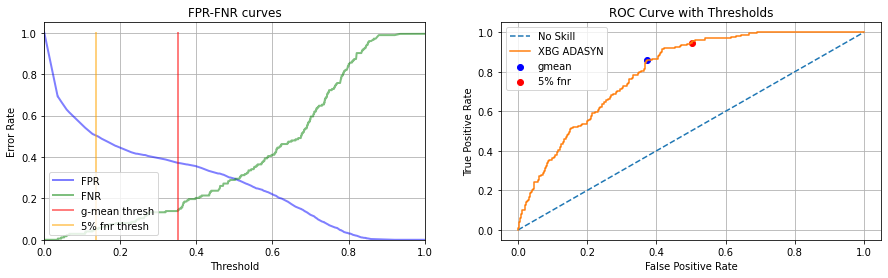

In [224]:
#GridSearch with cat_model for f1 score

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    iterations=1000,
    learning_rate=.01,
    verbose=False
)

param_grid = {
    'scale_pos_weight': [20,22],
    'random_strength': [0,1],
    'l2_leaf_reg': [1,5],
    'depth': [4,6],
}

cat_gsf1 = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='f1')
cat_gsf1.fit(train_X,train_y)

print('best score: {}'.format(cat_gsf1.best_score_))
print('best params: {}'.format(cat_gsf1.best_params_))

display_metrics_cat(cat_gsf1,val_pool,val_y)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

best score: 0.24140849921688665
best params: {'depth': 6, 'l2_leaf_reg': 5, 'random_strength': 0, 'scale_pos_weight': 15}
AUC: 0.8170450050402583,  logloss: 0.4133802053696284
accuracy: 0.7236
recall: 0.7225
precision: 0.1427
-------------------
For a .5 threshold:
[[1967  751]
 [  48  125]]
FPR: 0.2763  FNR: 0.2775
---------------------
G-Mean Threshold:
Best Threshold=0.331976, G-Mean=0.742
[[1660 1058]
 [  18  155]]
FPR: 0.3893  FNR: 0.104
---------------------
10% FNR Threshold:
Best Threshold: 0.3321
[[1660 1058]
 [  18  155]]
FPR: 0.3893  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.1599
[[1453 1265]
 [   9  164]]
FPR: 0.4654  FNR: 0.052


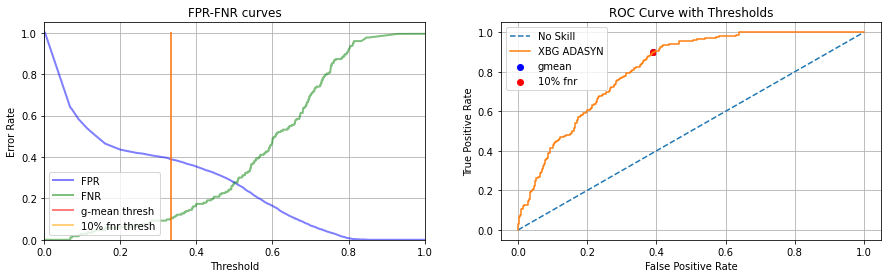

In [227]:
#GridSearch with cat_model for f1 score

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    iterations=1000,
    learning_rate=.01,
    verbose=False
)

param_grid = {
    'scale_pos_weight': [15,20],
    'random_strength': [0],
    'l2_leaf_reg': [1,5],
    'depth': [6,8,10],
}

cat_gsf2 = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='f1')
cat_gsf2.fit(train_X,train_y)

print('best score: {}'.format(cat_gsf2.best_score_))
print('best params: {}'.format(cat_gsf2.best_params_))

display_metrics_cat(cat_gsf2,val_pool,val_y)

## Best CatBoost Model ##

Two models performed very similarly, so we will run the test data against both of them at their 10% FNR thresholds to see which one performs better on the unseen data.

In [42]:
#Define both models

cat_best1 = catboost.CatBoostClassifier(
    cat_features = cat_features,
    learning_rate=.01,
    iterations=1000,
    depth=4,
    scale_pos_weight=22,
    l2_leaf_reg=5,
    random_strength=1,
    custom_loss=['AUC','Recall','Accuracy']
)

cat_best2 = catboost.CatBoostClassifier(
    cat_features = cat_features,
    learning_rate=.001,
    iterations=5000,
    depth=6,
    scale_pos_weight=22,
    l2_leaf_reg=5,
    random_strength=1,
    custom_loss=['AUC','Recall','Accuracy']
)

In [69]:
cat_best1.fit(train_pool, eval_set = val_pool, verbose=100,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6880709	test: 0.6879192	best: 0.6879192 (0)	total: 7.3ms	remaining: 7.29s
100:	learn: 0.5226882	test: 0.5326425	best: 0.5326425 (100)	total: 466ms	remaining: 4.15s
200:	learn: 0.4851890	test: 0.5016050	best: 0.5016050 (200)	total: 908ms	remaining: 3.61s
300:	learn: 0.4706581	test: 0.4909785	best: 0.4909785 (300)	total: 1.42s	remaining: 3.31s
400:	learn: 0.4617818	test: 0.4859080	best: 0.4859080 (400)	total: 1.9s	remaining: 2.83s
500:	learn: 0.4559916	test: 0.4834718	best: 0.4834718 (500)	total: 2.39s	remaining: 2.38s
600:	learn: 0.4511818	test: 0.4822575	best: 0.4822575 (600)	total: 2.89s	remaining: 1.92s
700:	learn: 0.4457893	test: 0.4802597	best: 0.4801956 (696)	total: 3.4s	remaining: 1.45s
800:	learn: 0.4414855	test: 0.4792926	best: 0.4792643 (798)	total: 3.88s	remaining: 963ms
900:	learn: 0.4347307	test: 0.4777331	best: 0.4776872 (897)	total: 4.38s	remaining: 482ms
999:	learn: 0.4280728	test: 0.4764063	best: 0.4763350 (948)	total: 4.89s	remaining: 0us

bestTest = 0.4763

It appears the model is potentially underfitting, but it performs better at 1000 iterations than if we let it run for longer.  If you look at AUC, it is slightly overfitting.

AUC: 0.8283909028655037,  logloss: 0.6253155173024246
accuracy: 0.5918
recall: 0.9422
precision: 0.1223
-------------------
For a .5 threshold:
[[1548 1170]
 [  10  163]]
FPR: 0.4305  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.651585, G-Mean=0.754
[[1681 1037]
 [  15  158]]
FPR: 0.3815  FNR: 0.0867
---------------------
10% FNR Threshold:
Best Threshold: 0.6553
[[1697 1021]
 [  18  155]]
FPR: 0.3756  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.2085
[[1416 1302]
 [   9  164]]
FPR: 0.479  FNR: 0.052


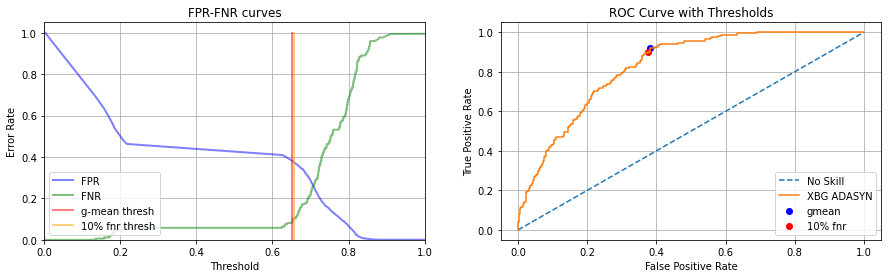

In [70]:
display_metrics_cat(cat_best1,val_pool,val_y)

In [43]:
cat_best2.fit(train_pool, eval_set = val_pool, verbose=1000,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6926143	test: 0.6925869	best: 0.6925869 (0)	total: 73.3ms	remaining: 6m 6s
1000:	learn: 0.5104783	test: 0.5231583	best: 0.5231583 (1000)	total: 6.05s	remaining: 24.2s
2000:	learn: 0.4736884	test: 0.4981273	best: 0.4981273 (2000)	total: 12.2s	remaining: 18.3s
3000:	learn: 0.4562981	test: 0.4894330	best: 0.4894330 (3000)	total: 19.1s	remaining: 12.7s
4000:	learn: 0.4445796	test: 0.4855404	best: 0.4855293 (3997)	total: 26.1s	remaining: 6.53s
4999:	learn: 0.4349118	test: 0.4834171	best: 0.4834161 (4995)	total: 33.4s	remaining: 0us

bestTest = 0.4834161133
bestIteration = 4995

Shrink model to first 4996 iterations.


This model also appears to potentially be underfitting, but it performs better than letting it fun to the minimum logloss.  While taking the iteration with best AUC also does not perform as well, the best performance appears to be somewhere in between where AUC begins to overfit and while logloss is slightly underfit.

AUC: 0.8261897774204937,  logloss: 0.6285505896562519
accuracy: 0.5905
recall: 0.9422
precision: 0.1219
-------------------
For a .5 threshold:
[[1544 1174]
 [  10  163]]
FPR: 0.4319  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.674519, G-Mean=0.756
[[1711 1007]
 [  17  156]]
FPR: 0.3705  FNR: 0.0983
---------------------
10% FNR Threshold:
Best Threshold: 0.6749
[[1713 1005]
 [  18  155]]
FPR: 0.3698  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.2107
[[1433 1285]
 [   9  164]]
FPR: 0.4728  FNR: 0.052


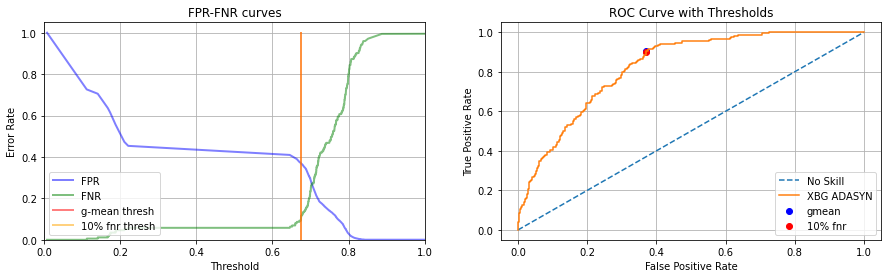

In [67]:
display_metrics_cat(cat_best2,val_pool,val_y)

In [71]:
#Test both models on the training data

#cat1 Best threshold is .6352; predict with test data
cat1_thresh=.6352
y_hat_prob=cat_best1.predict_proba(X_test_cat)[:,1]
y_hat_test=thresh_pred(y_hat_prob,cat1_thresh)
fpr,tpr,thresholds=roc_curve(y_test_cat,y_hat_prob)
print('Cat1 Results:')
print('AUC: {},  logloss: {}'.format(auc(fpr,tpr),log_loss(y_test_cat,y_hat_prob)))
print('accuracy: {}'.format(round(accuracy_score(y_test_cat,y_hat_test),4)))
print('recall: {}'.format(round(recall_score(y_test_cat,y_hat_test),4)))
print('precision: {}'.format(round(precision_score(y_test_cat,y_hat_test),4)))
print('-------------------')
print(confusion_matrix(y_test_cat,y_hat_test))
fpr,fnr=calc_fpr_fnr(y_test_cat,y_hat_test)
print('FPR: {}  FNR: {}'.format(round(fpr,4),round(fnr,4)))
print('-------------------')

#cat2 Best threshold is .671; predict with test data
cat2_thresh=.671
print('Cat2 Results:')
y_hat_prob=cat_best2.predict_proba(X_test_cat)[:,1]
y_hat_test=thresh_pred(y_hat_prob,cat2_thresh)
fpr,tpr,thresholds=roc_curve(y_test_cat,y_hat_prob)
print('AUC: {},  logloss: {}'.format(auc(fpr,tpr),log_loss(y_test_cat,y_hat_prob)))
print('accuracy: {}'.format(round(accuracy_score(y_test_cat,y_hat_test),4)))
print('recall: {}'.format(round(recall_score(y_test_cat,y_hat_test),4)))
print('precision: {}'.format(round(precision_score(y_test_cat,y_hat_test),4)))
print('-------------------')
print(confusion_matrix(y_test_cat,y_hat_test))
fpr,fnr=calc_fpr_fnr(y_test_cat,y_hat_test)
print('FPR: {}  FNR: {}'.format(round(fpr,4),round(fnr,4)))

Cat1 Results:
AUC: 0.8188913735271351,  logloss: 0.6105354895181015
accuracy: 0.6241
recall: 0.8831
precision: 0.1255
-------------------
[[2202 1422]
 [  27  204]]
FPR: 0.3924  FNR: 0.1169
-------------------
Cat2 Results:
AUC: 0.8189833529237504,  logloss: 0.6129091758346167
accuracy: 0.6506
recall: 0.8615
precision: 0.1314
-------------------
[[2309 1315]
 [  32  199]]
FPR: 0.3629  FNR: 0.1385


Results from both models are fairly similar. Shifting cat2's threshold slightly lower results in the same results except for 1 less false positive (but that threshold shift is based on the test data).

Ultimately, I'd choose cat2, because it has similar FNR and slightly less FPR.

# XGBoost vs. CatBoost #

Catboost and XGBoost both produced models with similar performance.  Below are the results of predictions with the test data set for both models. Of note, these are two different test data sets, since catboost handles categorical data and those were not one hot encoded before conducting train_test_split.

XGBoost Best Model:<br>
>Threshold: .5285<br>
AUC: 0.8045<br>
accuracy: 0.6329<br>
recall: 0.8831<br>
precision: 0.1281<br>
FPR: 0.383  FNR: 0.1169

CatBoost Best Model:<br>
>Threshold: .671<br>
AUC: 0.816<br>
accuracy: 0.6477<br>
recall: 0.8615<br>
precision: 0.1305<br>
FPR: 0.3659  FNR: 0.1385

I will select the CatBoost model since it does a better job at limiting FPR.  It also performed better on the validation set that was used to tune the thresholds (where each FNR was set to 10%).  Even if the threshold were adjusted on the test data so that FNR was at 10%, it would still outperform the XGBoost model in preventing FPs.

# Feature Importances #

### Prediction Value Changes ###

Catboost provides Prediction Value Changes through importance values for each feature. These show how much the average prediction changes if the feature value is changed. These are normalized and sum to 100.

Fault has the highest importance by a significant amount followed by BasePolicy, VehicleCategory, and PolicyType.

In [44]:
pvc=np.array(cat_best2.get_feature_importance(prettified=True))
pvc

array([['Fault', 56.23129982356912],
       ['BasePolicy', 8.902525008958445],
       ['VehicleCategory', 8.058497599090206],
       ['PolicyType', 4.828642181189363],
       ['AddressChange_Claim', 2.824900563034658],
       ['PastNumberOfClaims', 1.9713983826776509],
       ['MonthClaimed', 1.6638946631717328],
       ['Make', 1.515491697977388],
       ['Deductible', 1.4821574747866488],
       ['NumberOfSuppliments', 1.4182118796012069],
       ['DayOfWeek', 1.232248471057237],
       ['MaritalStatus', 0.9926856270333301],
       ['VehiclePrice', 0.9497798804233988],
       ['Age', 0.8639585298407362],
       ['Month', 0.8599131462803357],
       ['WeekOfMonth', 0.8140874840239944],
       ['DriverRating', 0.7910061153648653],
       ['AgeOfPolicyHolder', 0.7260468398615224],
       ['AgentType', 0.7216370103086669],
       ['WeekOfMonthClaimed', 0.7209179962609988],
       ['DayOfWeekClaimed', 0.6494515926637511],
       ['AgeOfVehicle', 0.5805497906651813],
       ['Sex', 0.51580

### Loss Function Change ###

Catboost also provides a metric that gives an approximated difference between the loss function value with and without the feature.  The higher the positive difference, the more important the feature is to the model.

Fault also tops this list, followed by NumberOfCars, BasePolicy, and Vehicle Category.  Interestingly, NumberofCars has a much lower importance when considering prediction value changes.

In [73]:
np.array(cat_best2.get_feature_importance(
    train_pool,
    'LossFunctionChange',
    prettified=True
))

array([['Fault', 0.09671625876268086],
       ['NumberOfCars', 0.016503400928953787],
       ['BasePolicy', 0.011293021125023598],
       ['VehicleCategory', 0.007500823512664509],
       ['PolicyType', 0.005429615198207626],
       ['Age', 0.005226491830372622],
       ['AddressChange_Claim', 0.004365275105131229],
       ['DriverRating', 0.0040332235215572165],
       ['Deductible', 0.0024875646870862835],
       ['MonthClaimed', 0.0020595499489448055],
       ['AgentType', 0.0015872705274533143],
       ['WeekOfMonth', 0.00150266506432184],
       ['VehiclePrice', 0.0014450892958549992],
       ['DayOfWeek', 0.0012700951005240602],
       ['Make', 0.0012538366739873559],
       ['WeekOfMonthClaimed', 0.0012219968735926643],
       ['AgeOfPolicyHolder', 0.0011402122951284694],
       ['PastNumberOfClaims', 0.0010910281142522728],
       ['Month', 0.0009782435827668707],
       ['AgeOfVehicle', 0.0009690585538549568],
       ['NumberOfSuppliments', 0.0008201602010310761],
       ['Mar

### Shap Values ###

Shap values show the impact on the model output (log odds) of each feature.  The summary plot plot the shap value, impact of the feature, for each observation, so we can see groups of very large positive or negative values.  Here we can visually see how much positive and negative impact Fault had on the prediction values of most of the observations in the training data.  This shows that the model places a heavier importance on this feature.  BasePolicy, VehicleCategory, and PolicyType also had greater importance for many of the predictions.

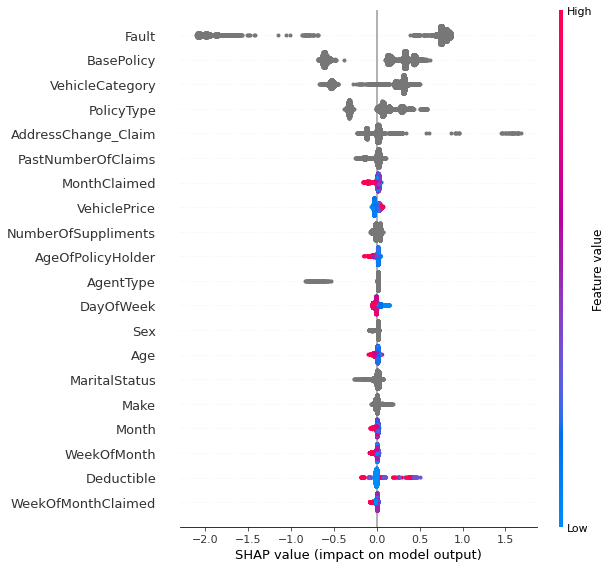

In [74]:
explainer = shap.TreeExplainer(cat_best2)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, train_X)

Shap dependence plots show the shap value plotted against the value of the feature for each observation.  These color of the marker is also shows the value of another feature to indicate if there are any interactions between those features.  

We see in the Fault dependence plot that observations where the policy holder was at fault all have strong positive impacts on the prediction.  Third party fault claims all had negative impacts.  The model has found that most fraud is committed when the policy holders are at fault and therefore this is an important distinguishing feature.

Furthermore, the color groupings in Base Policy, Policy Type, and Address Claim Change show that there is some level of interaction between these features and Fault.  For example, fraud would be more or less likely when the policy holder is at fault and has a certain type of base policy than if they just had that base policy alone.

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:636: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:712: MatplotlibDeprecationWarning:

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



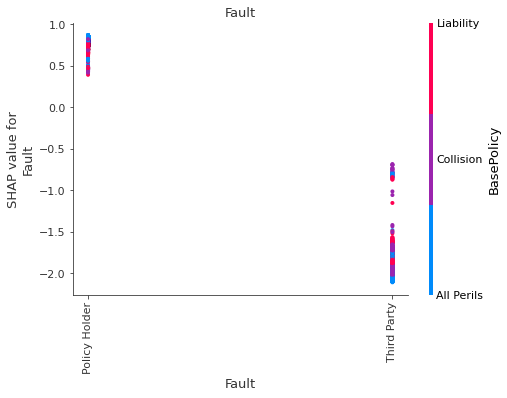

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:636: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:712: MatplotlibDeprecationWarning:

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



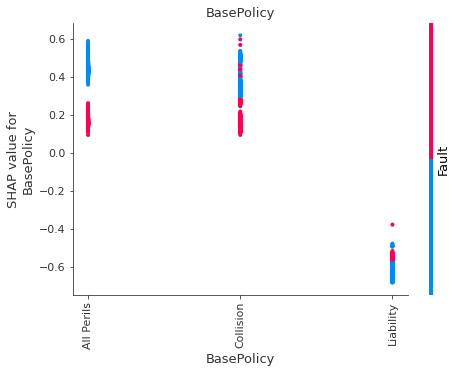

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:636: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:712: MatplotlibDeprecationWarning:

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



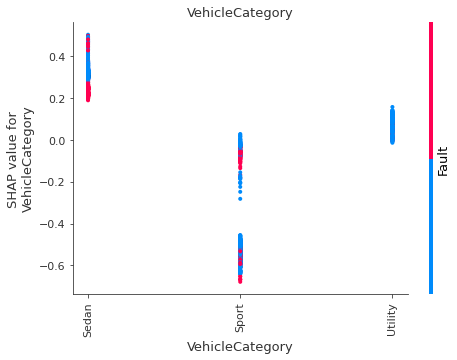

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:636: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:712: MatplotlibDeprecationWarning:

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



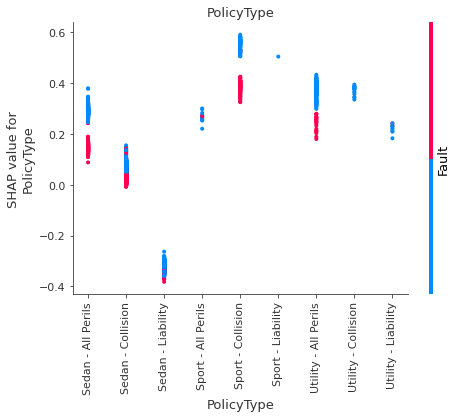

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:636: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.

/Users/fitz/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/shap/plots/_scatter.py:712: MatplotlibDeprecationWarning:

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



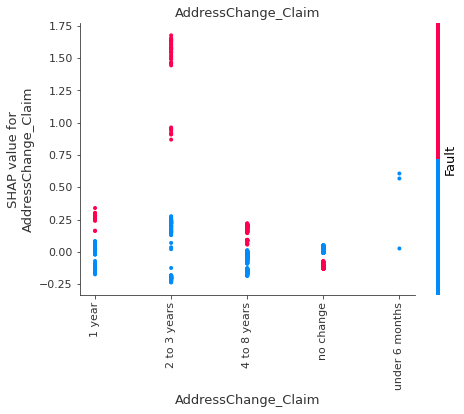

In [79]:
features=['Fault','BasePolicy','VehicleCategory','PolicyType','AddressChange_Claim']

for f in features:

    shap.dependence_plot(f, shap_values, train_X, title=f)

### Permutation Importance ###

Permutation importance evaluates the decrease in model score when a single feature is randomly shuffled in the data set (breaking its tie to the other the label). The more a score changes when the feature is permuted, the more importance it has to the model. I used the test data for this calculation to help highlight what features were important in the predictions and see if they were the same as those highlighted by the other metrics.

Fault is still the most important feature followed by BasePolicy, AddressChange_Claim, and VehicleCategory.

In [81]:
from sklearn.inspection import permutation_importance

In [95]:
result = permutation_importance(cat_best2, X_test_cat, y_test_cat, n_repeats=10,
                                random_state=0)
means=result.importances_mean
results=list(zip(val_X.columns,means))
pd.DataFrame(results,columns=['Feature','Importance']).sort_values('Importance',ascending=False)

,Feature,Importance
11,Fault,0.069027
26,BasePolicy,0.045214
24,AddressChange_Claim,0.003917
13,VehicleCategory,0.001686
16,DriverRating,0.000285
0,Month,0.000233
9,MaritalStatus,0.000233
1,WeekOfMonth,0.000156
7,WeekOfMonthClaimed,0.000156
2,DayOfWeek,0.000078


# Train a Simpler Model #

In [79]:
def try_diff_features(X,y,features):
    """
    X - all observations
    y - all targets
    features - list of features to try (subset of X features)
    
    Runs catboost model on data with just selected features.
    
    Outputs the FPR and FNR from the validation set, the 
    threshold selected for a 10% FNR, and the FPR and FNR from test set
    """
    
    #Select desired features
    X_top=X[features]
    
    #get list of categorical features in X
    dtypes=X_top.dtypes.reset_index()
    cat_features_10=dtypes[dtypes[0]=='object']['index'].to_list()

    #Split into test and train
    X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(
        X_top, y ,random_state=42, stratify=y
    )

    #Split training set into train and validation for catboost training

    train_X_10, val_X_10, train_y_10, val_y_10 = train_test_split(
        X_train_10, y_train_10, random_state=42, stratify=y_train_10
    )

    #create train_pool and validation_pool

    train_pool_10 = catboost.Pool(
        data = train_X_10,
        label = train_y_10,
        cat_features = cat_features_10
    )

    val_pool_10 = catboost.Pool(
        data = val_X_10,
        label = val_y_10,
        cat_features=cat_features_10
    )
    
    cat_top10 = catboost.CatBoostClassifier(
        cat_features = cat_features_10,
        learning_rate=.001,
        iterations=5000,
        depth=6,
        scale_pos_weight=22,
        l2_leaf_reg=5,
        random_strength=1,
        custom_loss=['AUC','Recall','Accuracy']
    )
    cat_top10.fit(train_pool_10, eval_set = val_pool_10, verbose=False,
             plot=False)
    
    y_prob=cat_top10.predict_proba(val_pool)[:,1]
    
    fpr,tpr,thresholds=roc_curve(val_y_10,y_prob)
    fnr=1-tpr
    
    #Calculate threshold corresponding to 10% FNR, make predictions
    thresh_10, idx = select_threshold_fnr(fnr, thresholds, .1)

    y_hat_10=thresh_pred(y_prob,thresh_10)

    ten_fpr,ten_fnr=calc_fpr_fnr(val_y_10,y_hat_10)
    
    #Make Predictions on the test data
    y_hat_prob_test=cat_top10.predict_proba(X_test_10)[:,1]
    y_hat_test_data=thresh_pred(y_hat_prob_test,thresh_10)
    test_fpr, test_fnr=calc_fpr_fnr(y_test_10,y_hat_test_data)
    
    return ten_fpr, ten_fnr, thresh_10, test_fpr, test_fnr

In [80]:
try_diff_features(X,y,pvc[0:12,0])

(0.37969094922737306,
 0.10404624277456648,
 0.6804960326593846,
 0.36920529801324503,
 0.09956709956709957)

In [86]:
#Loop through including top 3 to all 30 features

results=[]
#List of features in order of prediction value change importance
features=pvc[:,0]

for f in range(3,31):
    selected_feats=features[:f]
    val_fpr,val_fnr,thresh,test_fpr,test_fnr=try_diff_features(X,y,selected_feats)
    results.append([val_fpr,val_fnr,thresh,test_fpr,test_fnr])
    
results    

[[0.43414275202354674,
  0.11560693641618497,
  0.30981412199173286,
  0.4197019867549669,
  0.06926406926406926],
 [0.43414275202354674,
  0.11560693641618497,
  0.335745856196913,
  0.4197019867549669,
  0.06926406926406926],
 [0.20088300220750552,
  0.3872832369942196,
  0.7041204709798773,
  0.1945364238410596,
  0.43722943722943725],
 [0.35577630610743194,
  0.16184971098265896,
  0.6993309286669573,
  0.34299116997792495,
  0.17316017316017315],
 [0.3730684326710817,
  0.14450867052023122,
  0.6899351946376605,
  0.3672737306843267,
  0.1341991341991342],
 [0.3708609271523179,
  0.10404624277456648,
  0.6914748238039687,
  0.36258278145695366,
  0.11255411255411256],
 [0.37711552612214866,
  0.10404624277456648,
  0.6822701748451908,
  0.3689293598233996,
  0.10822510822510822],
 [0.37748344370860926,
  0.10404624277456648,
  0.6827912822469756,
  0.3667218543046358,
  0.09956709956709957],
 [0.3719646799116998,
  0.10404624277456648,
  0.684904371920799,
  0.36341059602649006,
 

In [87]:
pd.DataFrame(results,columns=['val_FPR','val_FNR','Threshold',
                             'test_FPR','test_FNR'])

,val_FPR,val_FNR,Threshold,test_FPR,test_FNR
0,0.434143,0.115607,0.309814,0.419702,0.069264
1,0.434143,0.115607,0.335746,0.419702,0.069264
2,0.200883,0.387283,0.704120,0.194536,0.437229
3,0.355776,0.161850,0.699331,0.342991,0.173160
4,0.373068,0.144509,0.689935,0.367274,0.134199
5,0.370861,0.104046,0.691475,0.362583,0.112554
6,0.377116,0.104046,0.682270,0.368929,0.108225
7,0.377483,0.104046,0.682791,0.366722,0.099567
8,0.371965,0.104046,0.684904,0.363411,0.103896
9,0.379691,0.104046,0.680496,0.369205,0.099567


### GridSearch with 19 feature model ###

In [47]:
#Catboost can handle categorical variables
#We'll use a diff version of X_train that hasn't been ohe'd
#X, y are before ohe

#Select desired features
features=pvc[:19,0]
X_top=X[features]
    
#get list of categorical features in X
dtypes=X_top.dtypes.reset_index()
cat_features_10=dtypes[dtypes[0]=='object']['index'].to_list()

#Split into test and train
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(
    X_top, y ,random_state=42, stratify=y
)

#Split training set into train and validation for catboost training

train_X_10, val_X_10, train_y_10, val_y_10 = train_test_split(
    X_train_10, y_train_10, random_state=42, stratify=y_train_10
)

#create train_pool and validation_pool

train_pool_10 = catboost.Pool(
    data = train_X_10,
    label = train_y_10,
    cat_features = cat_features_10
)

val_pool_10 = catboost.Pool(
    data = val_X_10,
    label = val_y_10,
    cat_features=cat_features_10
)

best score: 0.8205859459735354
best params: {'depth': 6, 'l2_leaf_reg': 3, 'scale_pos_weight': 20}
AUC: 0.825528376441365,  logloss: 0.5987115744020525
accuracy: 0.5891
recall: 0.9422
precision: 0.1216
-------------------
For a .5 threshold:
[[1540 1178]
 [  10  163]]
FPR: 0.4334  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.660754, G-Mean=0.758
[[1745  973]
 [  19  154]]
FPR: 0.358  FNR: 0.1098
---------------------
10% FNR Threshold:
Best Threshold: 0.6547
[[1711 1007]
 [  18  155]]
FPR: 0.3705  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.1922
[[1396 1322]
 [   9  164]]
FPR: 0.4864  FNR: 0.052


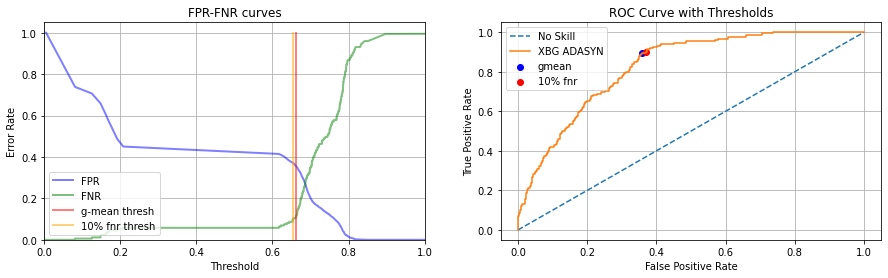

In [53]:
#GridSearch with cat_model for roc_auc

cat_top10 = catboost.CatBoostClassifier(
    cat_features = cat_features_10,
    learning_rate=.001,
    iterations=5000,
    depth=6,
    scale_pos_weight=22,
    l2_leaf_reg=5,
    random_strength=1,
    verbose=False
)

param_grid = {
    'scale_pos_weight': [20,25,30],
    'l2_leaf_reg': [1,3],
    'depth': [4,6,10]
}

cat_gs_10 = GridSearchCV(cat_top10, param_grid = param_grid, cv=3, 
                               scoring='roc_auc')
cat_gs_10.fit(train_X_10,train_y_10)

print('best score: {}'.format(cat_gs_10.best_score_))
print('best params: {}'.format(cat_gs_10.best_params_))

display_metrics_cat(cat_gs_10,val_pool_10,val_y_10)

In [56]:
cat_top10 = catboost.CatBoostClassifier(
    cat_features = cat_features_10,
    learning_rate=.001,
    iterations=5000,
    depth=6,
    scale_pos_weight=20,
    l2_leaf_reg=3,
    random_strength=1,
    verbose=False
)

cat_top10.fit(train_pool_10, eval_set = val_pool_10, verbose=2000,
             plot=True)

#top19 Best threshold is .6547; predict with test data
cat10_thresh=.6547
print('Cat Top 10 Results:')
y_hat_prob=cat_top10.predict_proba(X_test_10)[:,1]
y_hat_test=thresh_pred(y_hat_prob,cat10_thresh)
fpr,tpr,thresholds=roc_curve(y_test_10,y_hat_prob)
print('AUC: {},  logloss: {}'.format(auc(fpr,tpr),log_loss(y_test_10,y_hat_prob)))
print('accuracy: {}'.format(round(accuracy_score(y_test_10,y_hat_test),4)))
print('recall: {}'.format(round(recall_score(y_test_10,y_hat_test),4)))
print('precision: {}'.format(round(precision_score(y_test_10,y_hat_test),4)))
print('-------------------')
print(confusion_matrix(y_test_10,y_hat_test))
fpr,fnr=calc_fpr_fnr(y_test_10,y_hat_test)
print('FPR: {}  FNR: {}'.format(round(fpr,4),round(fnr,4)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6925772	test: 0.6926081	best: 0.6926081 (0)	total: 8.37ms	remaining: 41.8s
2000:	learn: 0.4760947	test: 0.5012428	best: 0.5012428 (2000)	total: 11.1s	remaining: 16.6s
4000:	learn: 0.4486712	test: 0.4905771	best: 0.4905771 (4000)	total: 23.4s	remaining: 5.85s
4999:	learn: 0.4399788	test: 0.4885994	best: 0.4885994 (4999)	total: 29.9s	remaining: 0us

bestTest = 0.4885993806
bestIteration = 4999

Cat Top 10 Results:
AUC: 0.8165847213860459,  logloss: 0.5848117916427418
accuracy: 0.6571
recall: 0.8701
precision: 0.1346
-------------------
[[2332 1292]
 [  30  201]]
FPR: 0.3565  FNR: 0.1299


# Model Selection #

Ultimately, a catboost model that uses 19 of the 30 features produces the best results, although the difference isn't significant. The test data (using a threshold meant to capture 90% of the fraud) was able to flag 87% of fraud while also flagging slightly less than 36% of the non-fraud as fraud.  These are not ideal outcomes, but depending on the cost of fraud vs. the cost of investigating claims that turn out not to be fraudulent, the threshold could be shifted to optimize the overall cost.

Although not in this notebook, models were tested using Logistic Regression, Random Forests, and Adaboost as well.  Random Over Sampling, SMOTE, and ADASYN were also tested for dealing with the class imbalance.  These models are available in the 'all_models_notebook' also in this repository.  Gradient boosting with class weighting performed the best overall and so that was the focus of this notebook.

Also I found that the best catboost models tended to appear to be underfitting to logloss but overfitting to AUC.  Increasing iterations did not improve the models and reducing iterations to fit to AUC did not improve performance either.  5000 iterations tended to work the best and typically meant that a model was selected that was somewhere between the best solution for AUC and Logloss.


In [65]:
#Final Model

final_model = catboost.CatBoostClassifier(
    cat_features = cat_features_10,
    learning_rate=.001,
    iterations=5000,
    depth=6,
    scale_pos_weight=20,
    l2_leaf_reg=3,
    custom_loss=['AUC','Recall','Accuracy'],
    random_strength=1,
    verbose=False
)

final_model.fit(train_pool_10, eval_set = val_pool_10, verbose=2000,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6925772	test: 0.6926081	best: 0.6926081 (0)	total: 9.93ms	remaining: 49.6s
2000:	learn: 0.4760947	test: 0.5012428	best: 0.5012428 (2000)	total: 11.9s	remaining: 17.8s
4000:	learn: 0.4486712	test: 0.4905771	best: 0.4905771 (4000)	total: 25.4s	remaining: 6.33s
4999:	learn: 0.4399788	test: 0.4885994	best: 0.4885994 (4999)	total: 32.8s	remaining: 0us

bestTest = 0.4885993806
bestIteration = 4999



AUC: 0.825528376441365,  logloss: 0.5987115744020525
accuracy: 0.5891
recall: 0.9422
precision: 0.1216
-------------------
For a .5 threshold:
[[1540 1178]
 [  10  163]]
FPR: 0.4334  FNR: 0.0578
---------------------
G-Mean Threshold:
Best Threshold=0.660754, G-Mean=0.758
[[1745  973]
 [  19  154]]
FPR: 0.358  FNR: 0.1098
---------------------
10% FNR Threshold:
Best Threshold: 0.6547
[[1711 1007]
 [  18  155]]
FPR: 0.3705  FNR: 0.104
---------------------
5% FNR Threshold:
Best Threshold: 0.1922
[[1396 1322]
 [   9  164]]
FPR: 0.4864  FNR: 0.052


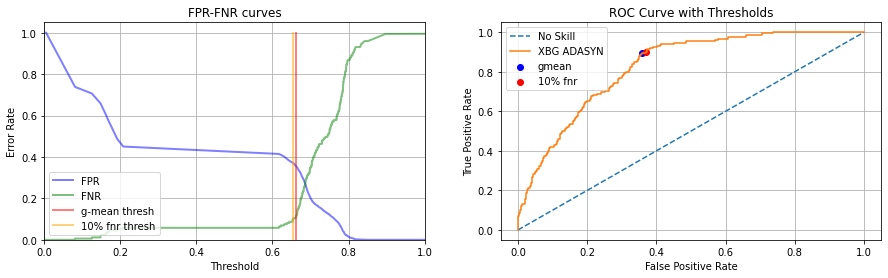

In [66]:
display_metrics_cat(final_model,val_pool_10,val_y_10)

In [68]:
#Best threshold is .6547; predict with test data
fnr10_thresh=.6547
print('Final Model Test Results:')
y_hat_prob=final_model.predict_proba(X_test_10)[:,1]
y_hat_test=thresh_pred(y_hat_prob,fnr10_thresh)
fpr,tpr,thresholds=roc_curve(y_test_10,y_hat_prob)
print('AUC: {},  logloss: {}'.format(auc(fpr,tpr),log_loss(y_test_10,y_hat_prob)))
print('accuracy: {}'.format(round(accuracy_score(y_test_10,y_hat_test),4)))
print('recall: {}'.format(round(recall_score(y_test_10,y_hat_test),4)))
print('precision: {}'.format(round(precision_score(y_test_10,y_hat_test),4)))
print('-------------------')
print(confusion_matrix(y_test_10,y_hat_test))
fpr,fnr=calc_fpr_fnr(y_test_10,y_hat_test)
print('FPR: {}  FNR: {}'.format(round(fpr,4),round(fnr,4)))

Final Model Test Results:
AUC: 0.8165847213860459,  logloss: 0.5848117916427418
accuracy: 0.6571
recall: 0.8701
precision: 0.1346
-------------------
[[2332 1292]
 [  30  201]]
FPR: 0.3565  FNR: 0.1299


Shap values for the final model show similar feature importances as the best catboost model with all the features included.  Fault still has the most impact, followed by BasePolicy, VehicleCategory, PolicyType, and AddressChange_Claim.

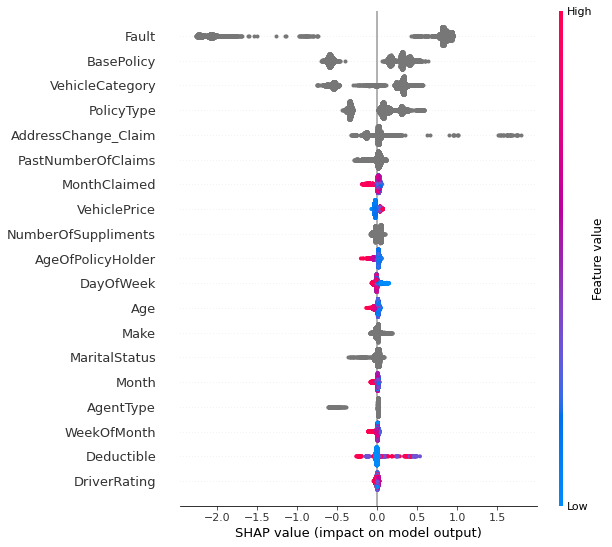

In [69]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(train_pool_10)
shap.summary_plot(shap_values, train_X_10)